In [1]:
# co2_rigorous_pretty_gold_v4_rawpool.py
from __future__ import annotations

from pathlib import Path
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# -----------------------------
# Config
# -----------------------------
ROOT = Path(".")
RESULTS_DIR = ROOT / "results"
SCORES_PATH = RESULTS_DIR / "co2_config_scores.csv"  # required for config plots

OUT_DIR = ROOT / "visualizations" / "co2_rigorous_pretty_gold_v4_rawpool"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# percent-type plot caps
PCT_ERR_YMAX = 0.05

# histogram bin specs
HIST_BINS = 40
HIST_XMAX_NONTCN = 0.04
HIST_XMAX_TCN = 0.08

DEFAULT_MODELS = ["MLP", "RNN", "LSTM", "GRU", "TCN"]

# Market abbreviations
MARKET_ABBR = {
    "Australia": "AU",
    "California": "US(CA)",
    "EU_EEX": "EU",
    "NewZealand": "NZ",
    "RGGI": "US(NE)",
    "Shanghai": "CN",
}

In [3]:
# -----------------------------
# Style
# -----------------------------
plt.rcParams.update(
    {
        "figure.dpi": 110,
        "savefig.dpi": 220,
        "axes.grid": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "semibold",
        "font.size": 11,
    }
)

MODEL_COLORS = {
    "MLP":  "#4C78A8",
    "RNN":  "#F58518",
    "LSTM": "#54A24B",
    "GRU":  "#E45756",
    "TCN":  "#B279A2",
}
DEFAULT_COLOR = "#777777"
R2_RED = "#D62728"


In [4]:
# -----------------------------
# Utilities
# -----------------------------
def savefig(name: str, fig: plt.Figure | None = None) -> None:
    path = OUT_DIR / name
    if fig is None:
        fig = plt.gcf()
    fig.savefig(path, dpi=220, bbox_inches="tight")
    print("[SAVED]", path)

def _is_naive(model_name: str) -> bool:
    s = str(model_name).strip().lower()
    return ("naive" in s) or (s == "naive_last_price") or (s == "naive")

def try_display(df: pd.DataFrame, title: str | None = None, n: int = 30) -> None:
    if title:
        print("\n" + title)
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df.head(n).to_string(index=False))

def parse_hyperparams(s: str) -> dict:
    """
    Robustly parse strings like:
      "{""hidden_units"": 32, ""num_layers"": 2, ...}"
    or normal JSON, or Python dict literals.
    """
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return {}
    st = str(s).strip()
    if not st:
        return {}

    # strip outer quotes if present
    if len(st) >= 2 and ((st[0] == st[-1] == '"') or (st[0] == st[-1] == "'")):
        st = st[1:-1].strip()

    # fix doubled quotes
    st2 = st.replace('""', '"')

    for cand in (st, st2):
        try:
            obj = json.loads(cand)
            if isinstance(obj, dict):
                return obj
        except Exception:
            pass

    for cand in (st, st2):
        try:
            obj = ast.literal_eval(cand)
            if isinstance(obj, dict):
                return obj
        except Exception:
            pass

    return {}

def deep_find(d: dict, keys: list[str]):
    for k in keys:
        if k in d:
            return d.get(k)
    return np.nan

HP_ORDER = ["hidden_units", "num_layers", "activation", "learning_rate", "epochs"]

def add_standard_hp_columns(cfg: pd.DataFrame, hp_dict_col: str = "hp_dict") -> pd.DataFrame:
    cfg = cfg.copy()

    def hidden_units_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        if r["model"] == "TCN":
            return deep_find(d, ["channels", "tcn_channels", "hidden_units", "units"])
        return deep_find(d, ["hidden_units", "units"])

    def num_layers_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        if r["model"] == "TCN":
            return deep_find(d, ["blocks", "tcn_blocks", "num_layers", "layers", "depth"])
        return deep_find(d, ["num_layers", "layers", "depth"])

    def activation_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["activation", "act"])

    def lr_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["learning_rate", "lr"])

    def epochs_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["epochs", "n_epochs", "epoch"])

    cfg["hp_hidden_units"]  = cfg.apply(hidden_units_row, axis=1)
    cfg["hp_num_layers"]    = cfg.apply(num_layers_row, axis=1)
    cfg["hp_activation"]    = cfg.apply(activation_row, axis=1)
    cfg["hp_learning_rate"] = cfg.apply(lr_row, axis=1)
    cfg["hp_epochs"]        = cfg.apply(epochs_row, axis=1)
    return cfg

In [5]:
# -----------------------------
# Config hist panel
# -----------------------------
def plot_cfg_hist_panel(cfg_overall: pd.DataFrame, models: list[str]):
    """
    Histogram panel:
      - non-TCN: x in [0, 0.04], 40 bins
      - TCN: x in [0, 0.08], 40 bins
    y-axis: share per bin = count / n_configs (n/405 style)
    """
    n = len(models)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.0 * ncols, 3.9 * nrows), constrained_layout=True)
    axes = np.array(axes).ravel()

    for ax, m in zip(axes, models):
        sub = cfg_overall[cfg_overall["model"] == m].copy()
        vals = sub["mean_MAPE"].astype(float).values
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{m}", ha="center", va="center")
            continue

        x_max = HIST_XMAX_TCN if m == "TCN" else HIST_XMAX_NONTCN
        edges = np.linspace(0.0, x_max, HIST_BINS + 1)

        vals = np.clip(vals, 0.0, x_max)
        weights = np.ones_like(vals) / max(1, vals.size)  # share per bin

        ax.hist(vals, bins=edges, weights=weights, alpha=0.9,
                color=MODEL_COLORS.get(m, DEFAULT_COLOR))
        ax.set_title(m)
        ax.set_xlabel("MAPE")
        ax.set_ylabel("Share")
        ax.set_xlim(0.0, x_max)
        ax.set_xticks(np.linspace(0.0, x_max, 5))

    for k in range(len(models), len(axes)):
        axes[k].axis("off")

    fig.suptitle("MODEL", y=1.02, fontsize=14, fontweight="semibold")
    savefig("panel_hist_config_MAPE.png", fig=fig)
    plt.show()

In [6]:
# -----------------------------
# HP sensitivity (2x3) per model
# -----------------------------
def plot_hp_sensitivity_panel(cfg_overall: pd.DataFrame, cfg_market: pd.DataFrame, model: str):
    """
    2x3 grid
    First five: mean MAPE by HP value (from cfg_overall; each config counted once).
    Sixth: RAW POOLING across markets:
        Pool all (market, model, config) rows for this model (~2430 pts),
        then sort:
          MAPE: worst -> best (descending)
          R2:   worst -> best (ascending)
        Plot both (MAPE shaded, R² red solid), with fixed axes.
    """
    sub = cfg_overall[cfg_overall["model"] == model].copy()
    if sub.empty:
        return

    fig, axes = plt.subplots(2, 3, figsize=(14.6, 8.3), constrained_layout=True)
    axes = np.array(axes).ravel()

    hp_map = {
        "hidden_units": "hp_hidden_units",
        "num_layers": "hp_num_layers",
        "activation": "hp_activation",
        "learning_rate": "hp_learning_rate",
        "epochs": "hp_epochs",
    }

    # --- first five: mean MAPE by hp value (configs count once) ---
    for i, hp_name in enumerate(HP_ORDER):
        ax = axes[i]
        col = hp_map[hp_name]
        if col not in sub.columns or sub[col].dropna().empty:
            ax.axis("off")
            ax.text(0.5, 0.5, hp_name, ha="center", va="center", fontsize=12, color="#444444")
            continue

        g = sub.groupby(col, dropna=True)["mean_MAPE"].mean().reset_index()
        if g.shape[0] < 2:
            ax.axis("off")
            ax.text(0.5, 0.5, hp_name, ha="center", va="center", fontsize=12, color="#444444")
            continue

        # stable ordering
        if hp_name in ("hidden_units", "num_layers", "epochs", "learning_rate"):
            try:
                g["_k"] = g[col].astype(float)
                g = g.sort_values("_k").drop(columns="_k")
            except Exception:
                g[col] = g[col].astype(str)
                g = g.sort_values(col)
        else:
            order = ["relu", "tanh", "swish"]
            g[col] = g[col].astype(str)
            g["_k"] = g[col].map({v: j for j, v in enumerate(order)}).fillna(999).astype(int)
            g = g.sort_values("_k").drop(columns="_k")

        x = np.arange(len(g))
        ax.bar(x, g["mean_MAPE"].values, color=MODEL_COLORS.get(model, DEFAULT_COLOR), alpha=0.9)
        ax.set_xticks(x)
        ax.set_xticklabels(g[col].astype(str).values, rotation=25, ha="right")
        ax.set_title(hp_name)
        ax.set_ylabel("MAPE")
        ax.set_ylim(0.0, PCT_ERR_YMAX)

    # --- sixth: RAW pooled rank curves across markets ---
    ax = axes[5]
    subm = cfg_market[cfg_market["model"] == model].copy()
    if subm.empty:
        ax.axis("off")
        fig.suptitle(model, y=1.02, fontsize=16, fontweight="semibold")
        savefig(f"hp_sensitivity_{model}.png", fig=fig)
        plt.show()
        return

    # pool all markets: one point per (market, config) already in cfg_market
    mvals = subm["MAPE"].astype(float).values
    rvals = subm["R2"].astype(float).values
    mvals = mvals[np.isfinite(mvals)]
    rvals = rvals[np.isfinite(rvals)]

    if mvals.size < 20 or rvals.size < 20:
        ax.axis("off")
        fig.suptitle(model, y=1.02, fontsize=16, fontweight="semibold")
        savefig(f"hp_sensitivity_{model}.png", fig=fig)
        plt.show()
        return

    # sort worst -> best
    y_m = np.sort(mvals)[::-1]   # MAPE worst -> best
    y_r = np.sort(rvals)         # R2   worst -> best

    L = int(min(y_m.size, y_r.size))
    y_m = y_m[:L]
    y_r = y_r[:L]
    x = np.arange(1, L + 1)

    mape_cap = 0.10 if model == "TCN" else 0.05
    y_m_clip = np.clip(y_m, 0.0, mape_cap)
    y_r_clip = np.clip(y_r, 0.0, 1.0)

    ax.plot(x, y_m_clip, linewidth=2.2, color=MODEL_COLORS.get(model, DEFAULT_COLOR))
    ax.fill_between(x, y_m_clip, y2=mape_cap, alpha=0.18, color=MODEL_COLORS.get(model, DEFAULT_COLOR))
    ax.set_xlabel("Rank")
    ax.set_ylabel("MAPE")
    ax.set_xlim(1, L)
    ax.set_ylim(0.0, mape_cap)
    ax.invert_yaxis()
    ax.set_xticks([1, int(L*0.25), int(L*0.5), int(L*0.75), L])

    ax2 = ax.twinx()
    ax2.plot(x, y_r_clip, linewidth=2.6, color=R2_RED)
    ax2.set_ylabel("R²", color=R2_RED)
    ax2.tick_params(axis="y", colors=R2_RED)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_yticks(np.linspace(0.0, 1.0, 6))

    fig.suptitle(model, y=1.02, fontsize=16, fontweight="semibold")
    savefig(f"hp_sensitivity_{model}.png", fig=fig)
    plt.show()

[INFO] scores rows: 12150
[INFO] markets: ['AU', 'US(CA)', 'EU', 'NZ', 'US(NE)', 'CN']
[INFO] models: ['MLP', 'RNN', 'LSTM', 'GRU', 'TCN']
[INFO] unique configs: 2025
[INFO] cfg_market rows (market-model-config): 12150
[INFO] Output dir: visualizations/co2_rigorous_pretty_gold_v4_rawpool
[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/panel_hist_config_MAPE.png


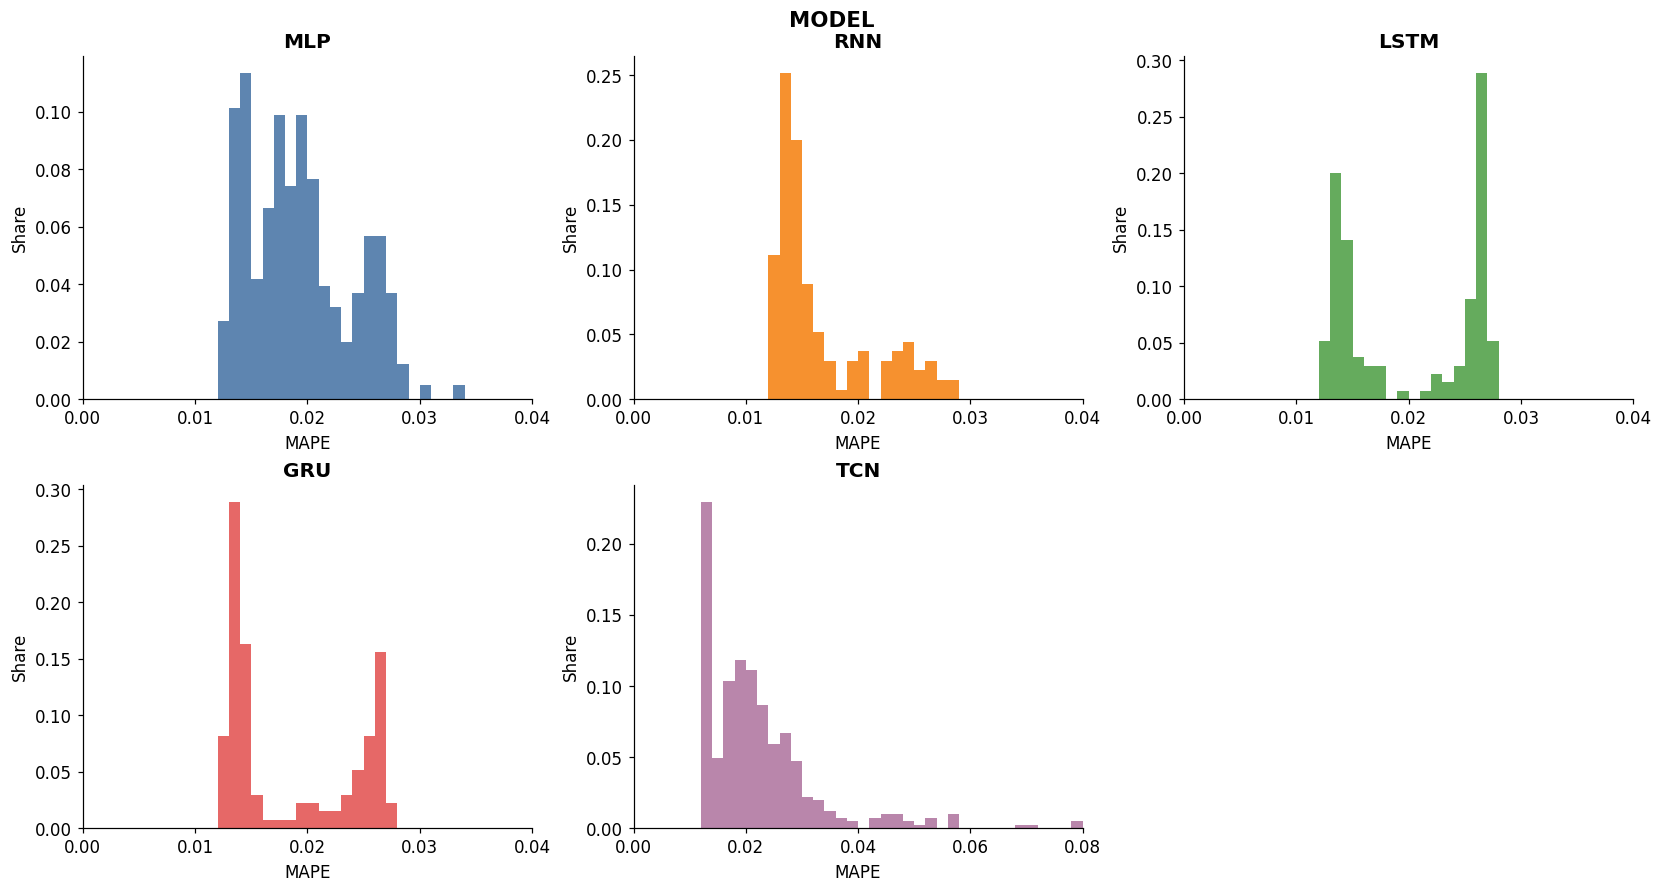

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_MLP.png


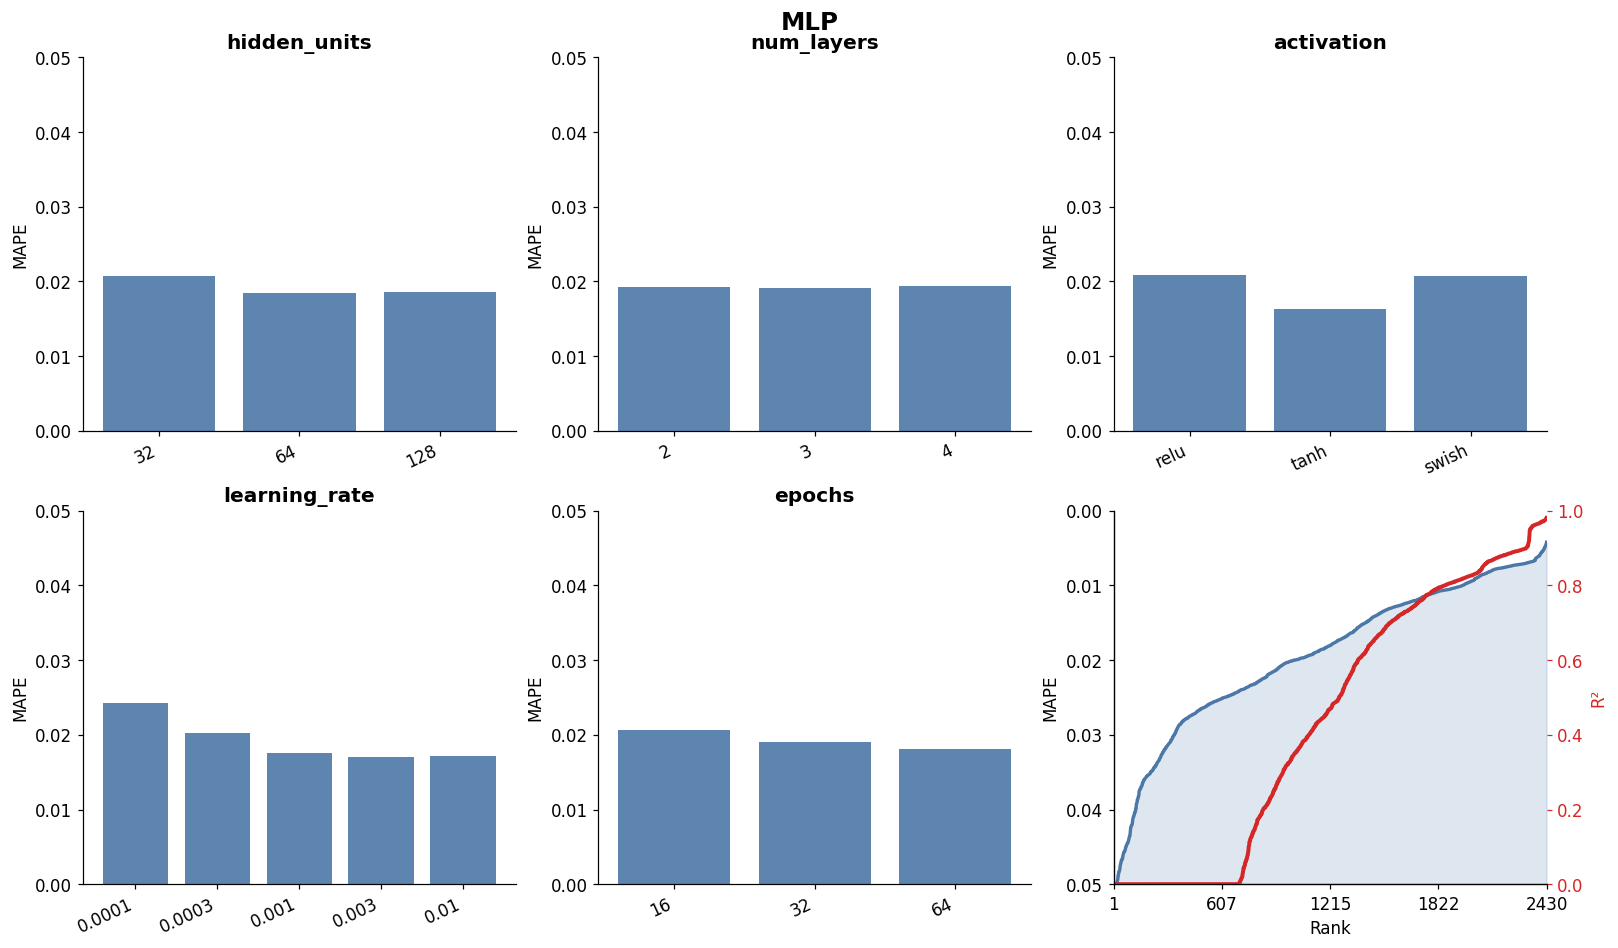

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_RNN.png


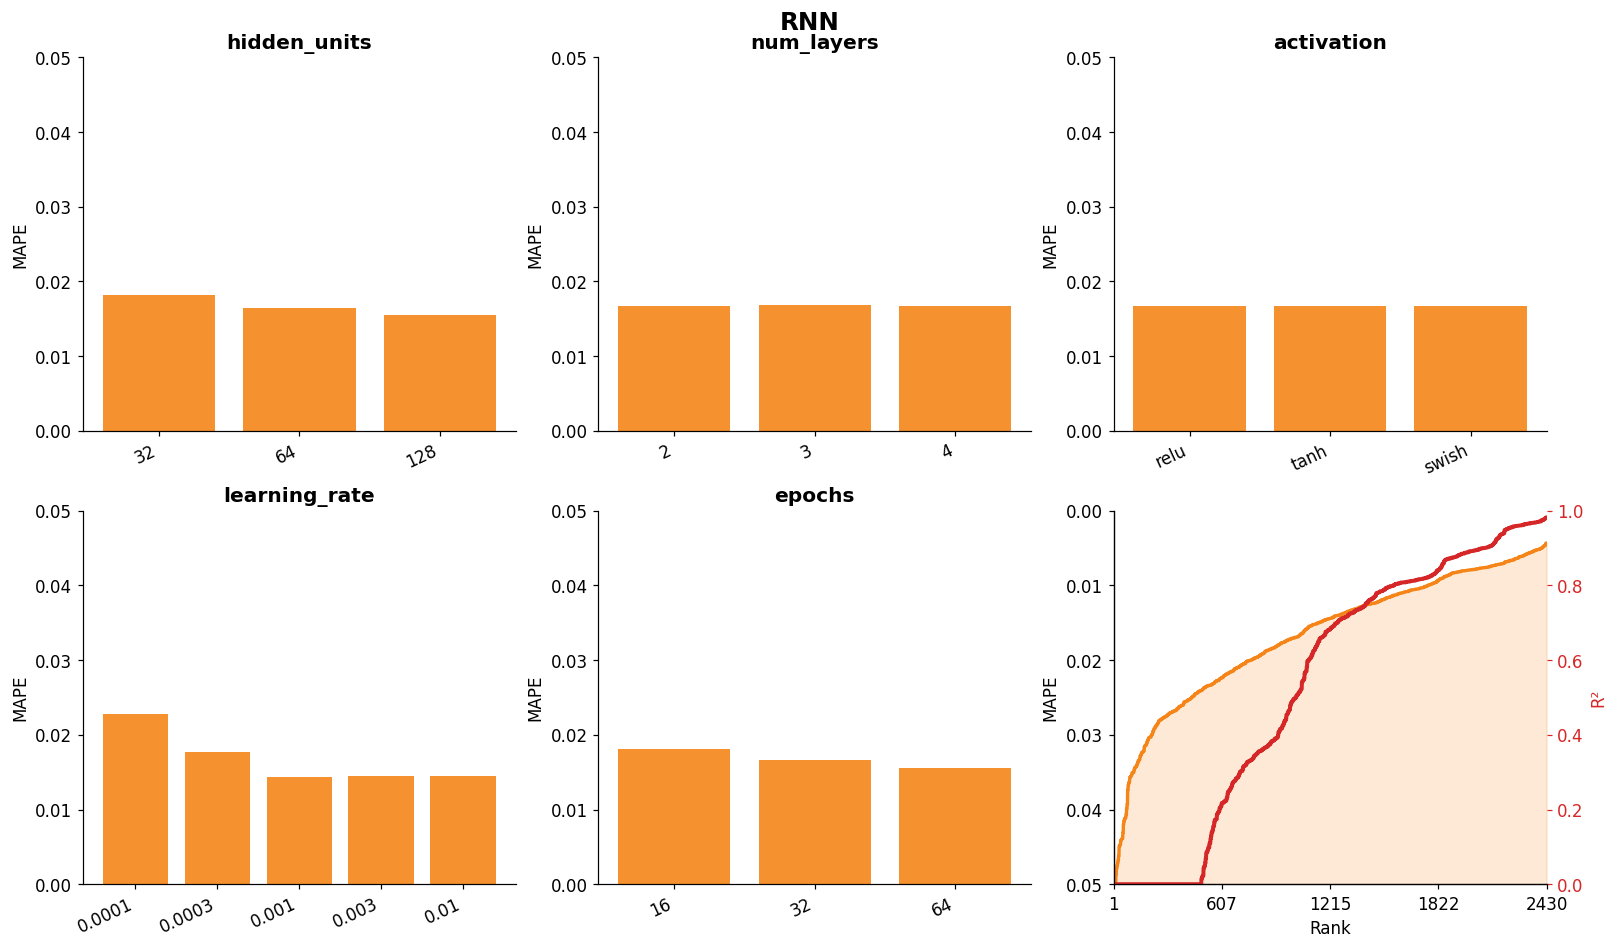

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_LSTM.png


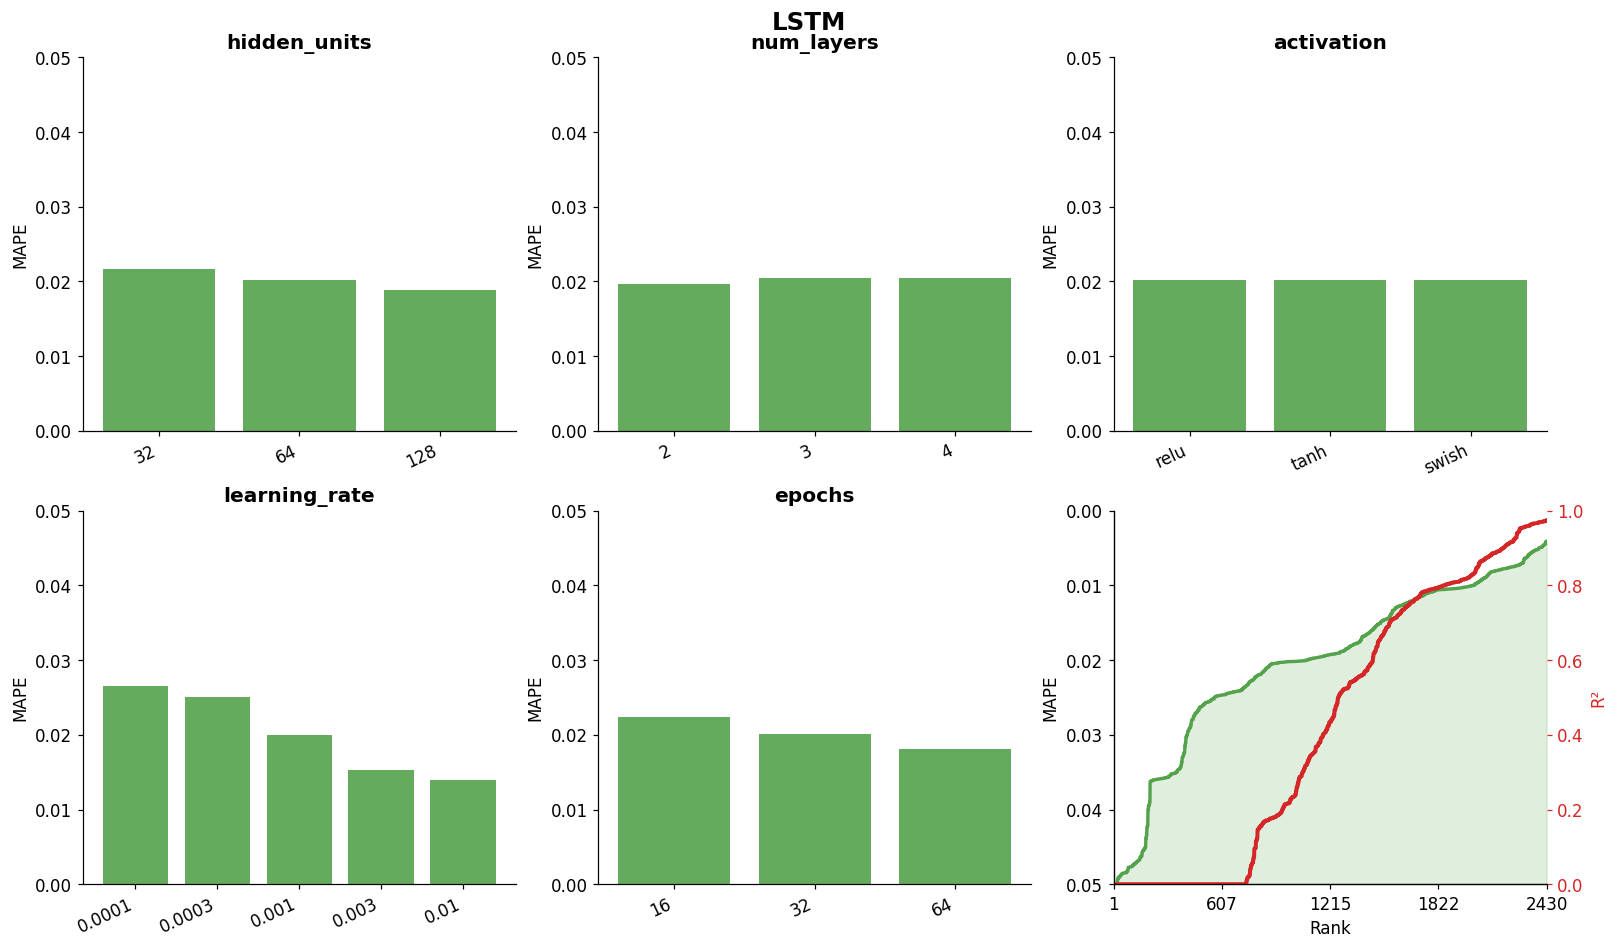

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_GRU.png


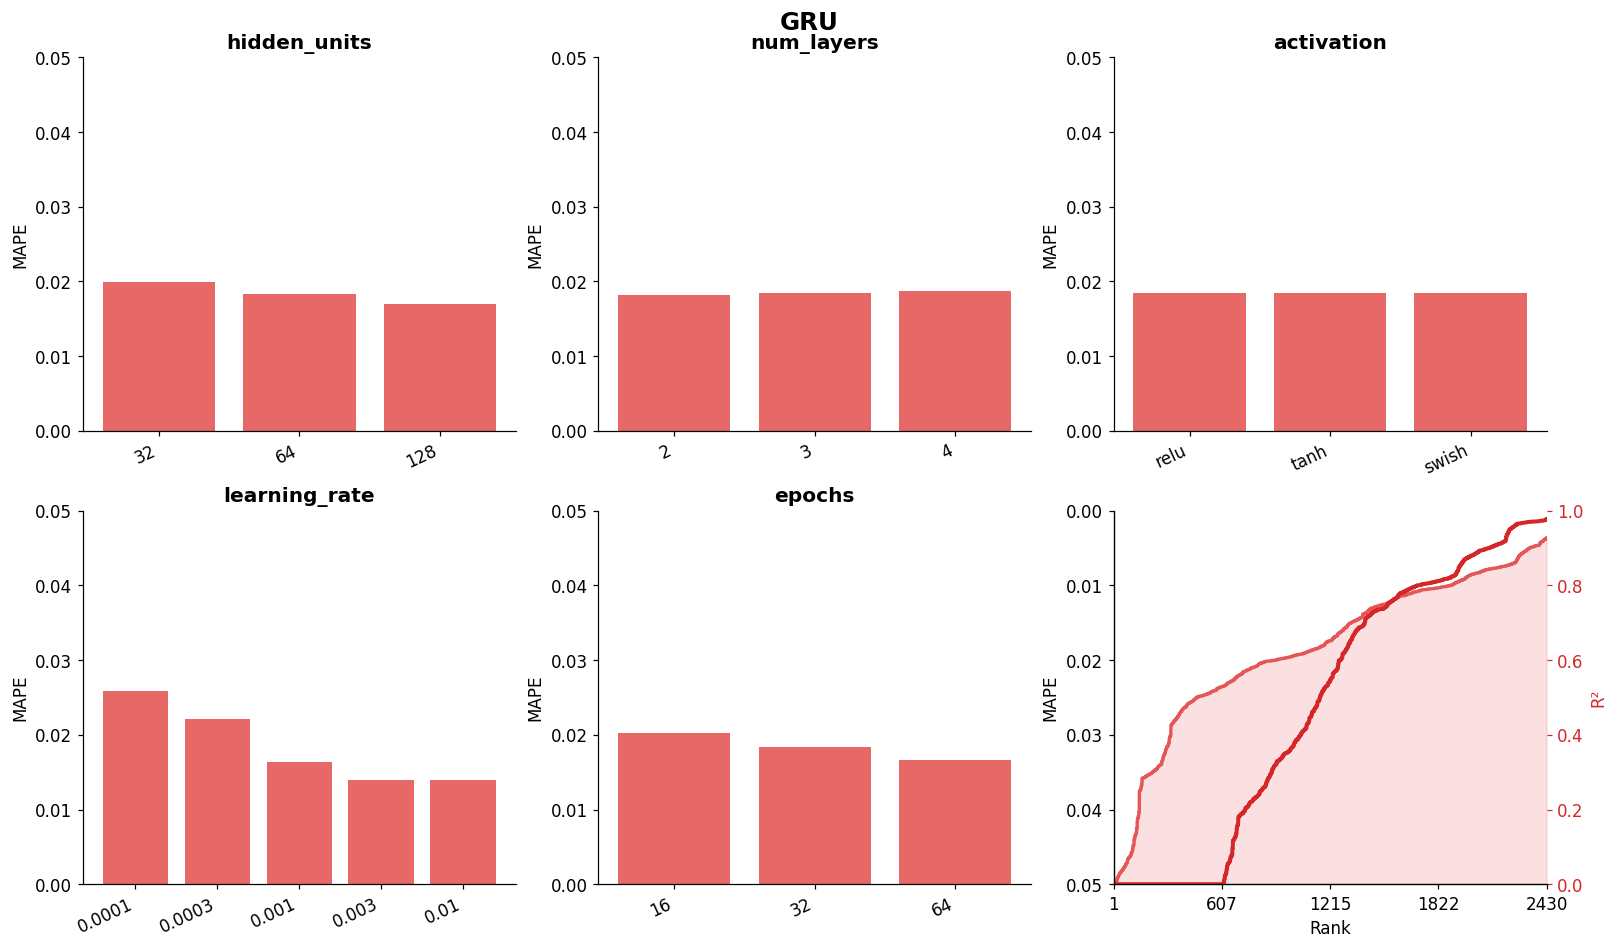

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_TCN.png


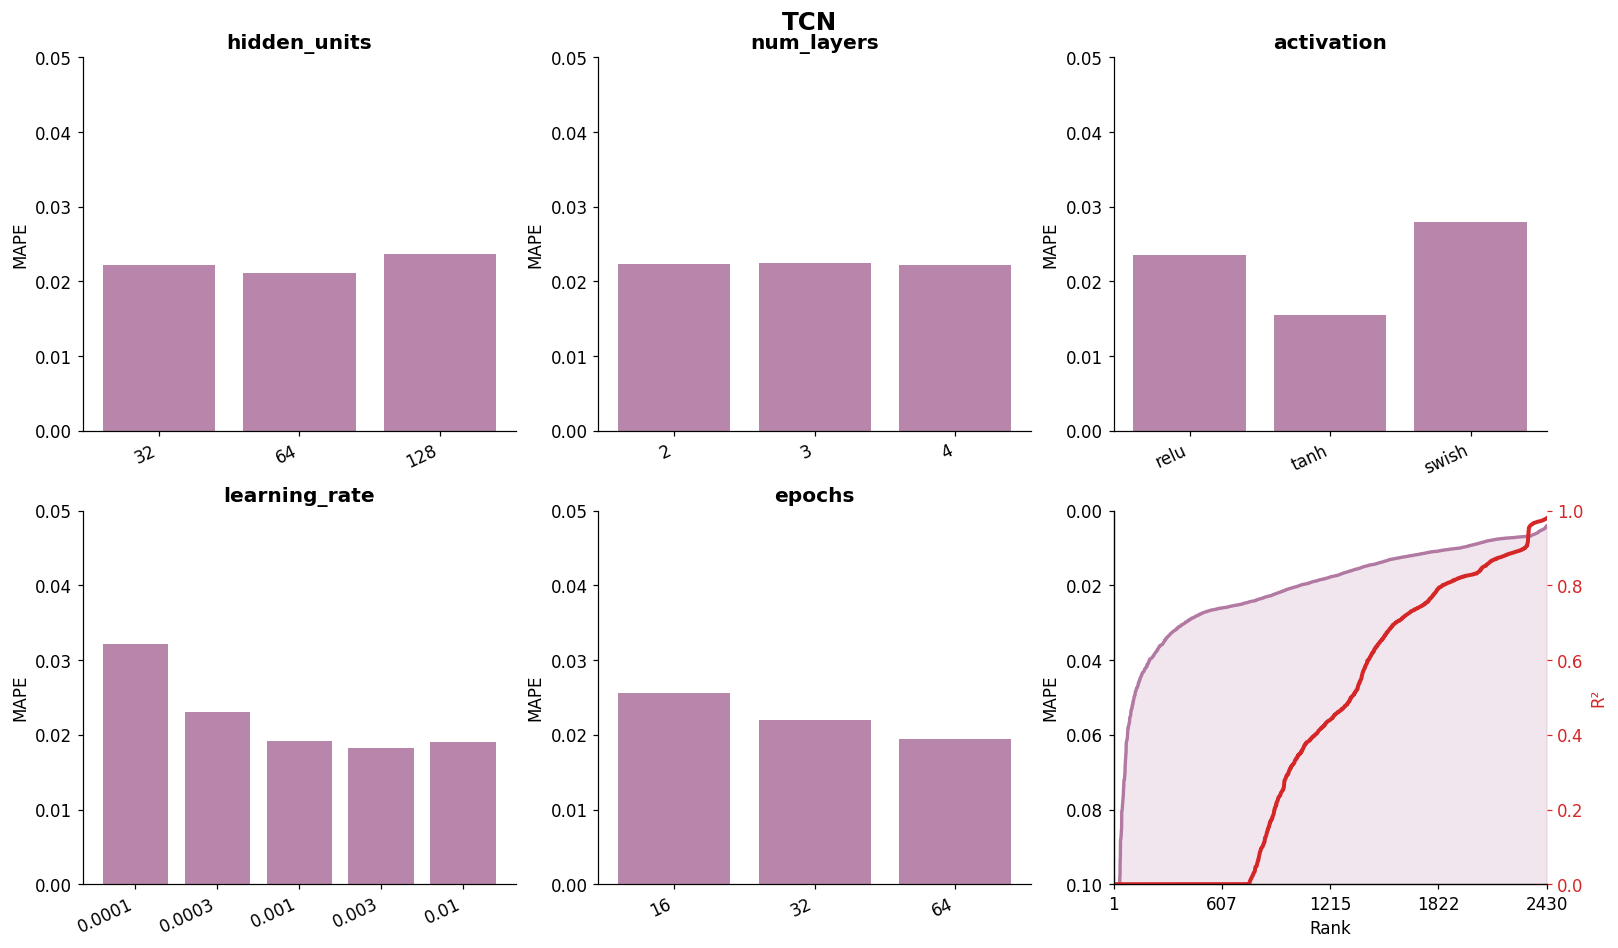

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/configs_ranked_all.csv
[DONE] Outputs saved to: visualizations/co2_rigorous_pretty_gold_v4_rawpool


In [7]:
# =============================================================================
# MAIN: read co2_config_scores.csv, build cfg_market + cfg_overall, plot
# =============================================================================
if not SCORES_PATH.exists():
    alt = Path("/mnt/data/co2_config_scores.csv")
    if alt.exists():
        SCORES_PATH = alt
    else:
        raise FileNotFoundError(f"Missing {SCORES_PATH}")

scores = pd.read_csv(SCORES_PATH)

scores["model"] = scores["model"].astype(str)
scores = scores[~scores["model"].map(_is_naive)].copy()
scores["model"] = scores["model"].str.upper()

# detect hyperparam column robustly
hyper_col = None
for cand in ["hyperparams_json", "model_hyperparameters_dict", "model_hyperparameters", "hyperparams", "config_json"]:
    if cand in scores.columns:
        hyper_col = cand
        break
if hyper_col is None:
    raise ValueError("No hyperparameter JSON column found in co2_config_scores.csv")

scores["hp_dict"] = scores[hyper_col].map(parse_hyperparams)

# cfg_market: one row per (market, model, config) with MAPE/R2 from file (collapse duplicates if any)
cfg_market = (
    scores.groupby(["market", "model", hyper_col], as_index=False)
          .agg(
              MAPE=("MAPE", "mean"),
              R2=("R2", "mean"),
          )
)
cfg_market["market_abbr"] = cfg_market["market"].map(lambda x: MARKET_ABBR.get(x, x))

# cfg_overall: one row per (model, config), averaged across markets (used for hist + hp bars)
cfg_overall = (
    cfg_market.groupby(["model", hyper_col], as_index=False)
              .agg(
                  mean_MAPE=("MAPE", "mean"),
                  mean_R2=("R2", "mean"),
                  markets_covered=("market", "nunique"),
              )
)

# attach hp_dict (first occurrence of that config string per model)
cfg_hp = scores.drop_duplicates(subset=["model", hyper_col], keep="first")[["model", hyper_col, "hp_dict"]]
cfg_overall = cfg_overall.merge(cfg_hp, on=["model", hyper_col], how="left")
cfg_overall = add_standard_hp_columns(cfg_overall, hp_dict_col="hp_dict")

# models present (preferred order)
cfg_models = [m for m in DEFAULT_MODELS if m in sorted(cfg_overall["model"].unique())]
if not cfg_models:
    cfg_models = sorted(cfg_overall["model"].unique().tolist())

markets_present = sorted(cfg_market["market"].unique().tolist())

print("[INFO] scores rows:", scores.shape[0])
print("[INFO] markets:", [MARKET_ABBR.get(m, m) for m in markets_present])
print("[INFO] models:", cfg_models)
print("[INFO] unique configs:", cfg_overall.shape[0])
print("[INFO] cfg_market rows (market-model-config):", cfg_market.shape[0])
print("[INFO] Output dir:", OUT_DIR)

# histogram panel (per-config mean across markets)
plot_cfg_hist_panel(cfg_overall, cfg_models)

# hp sensitivity per model (subplot #6 uses pooled raw market rows)
for m in cfg_models:
    plot_hp_sensitivity_panel(cfg_overall, cfg_market, m)

# save full ranked config table
ranked_all = (
    cfg_overall.sort_values(["model", "markets_covered", "mean_MAPE", "mean_R2"],
                            ascending=[True, False, True, False])
              .reset_index(drop=True)
)
out_csv = OUT_DIR / "configs_ranked_all.csv"
ranked_all.to_csv(out_csv, index=False)
print("[SAVED]", out_csv)

print("[DONE] Outputs saved to:", OUT_DIR)


[INFO] scores rows: 12150
[INFO] markets: ['AU', 'US(CA)', 'EU', 'NZ', 'US(NE)', 'CN']
[INFO] models: ['MLP', 'RNN', 'LSTM', 'GRU', 'TCN']
[INFO] unique configs: 2025
[INFO] cfg_market rows (market-model-config): 12150
[INFO] Output dir: visualizations/co2_rigorous_pretty_gold_v4_rawpool
[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/heatmap_best_MAPE.png


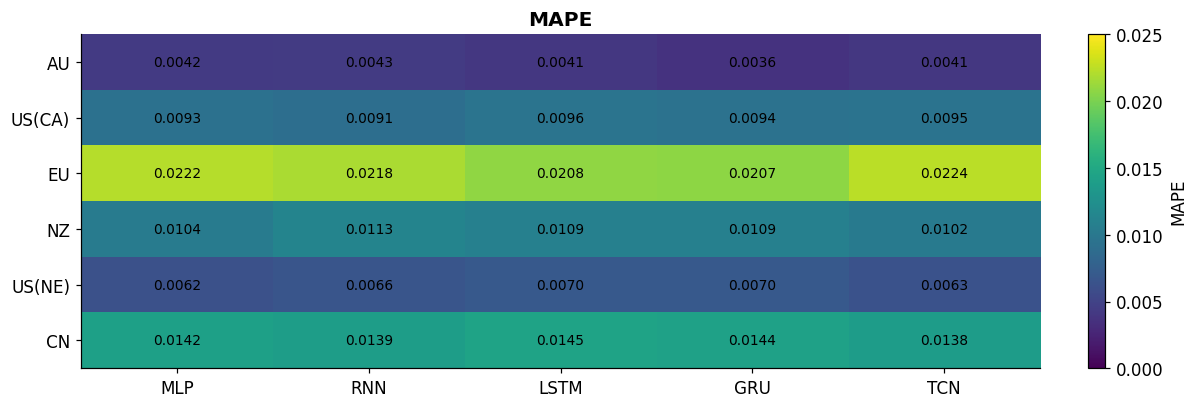

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/heatmap_R2_at_best_MAPE.png


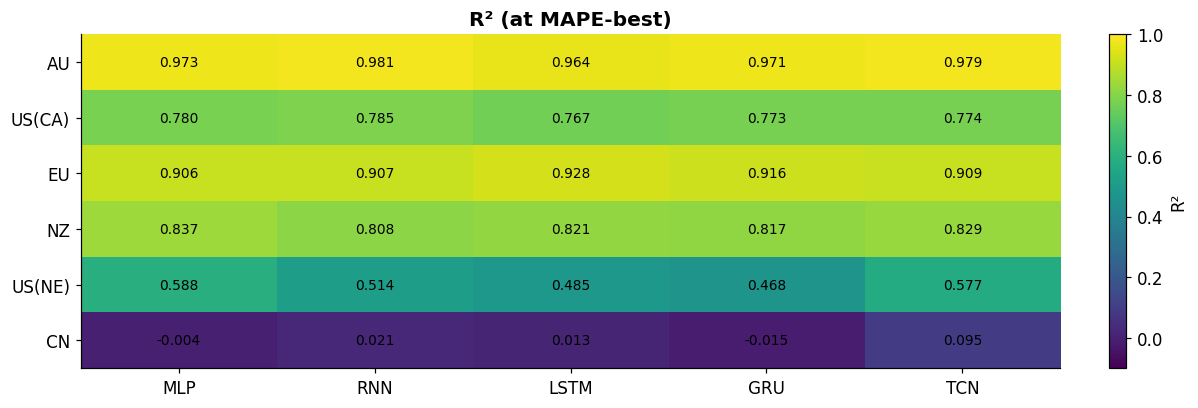

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/heatmap_best_R2.png


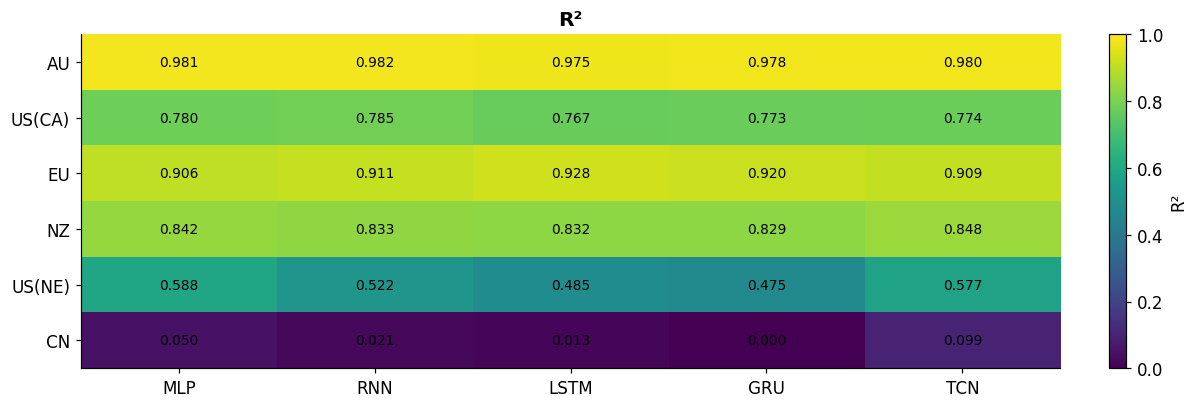

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/panel_hist_config_MAPE.png


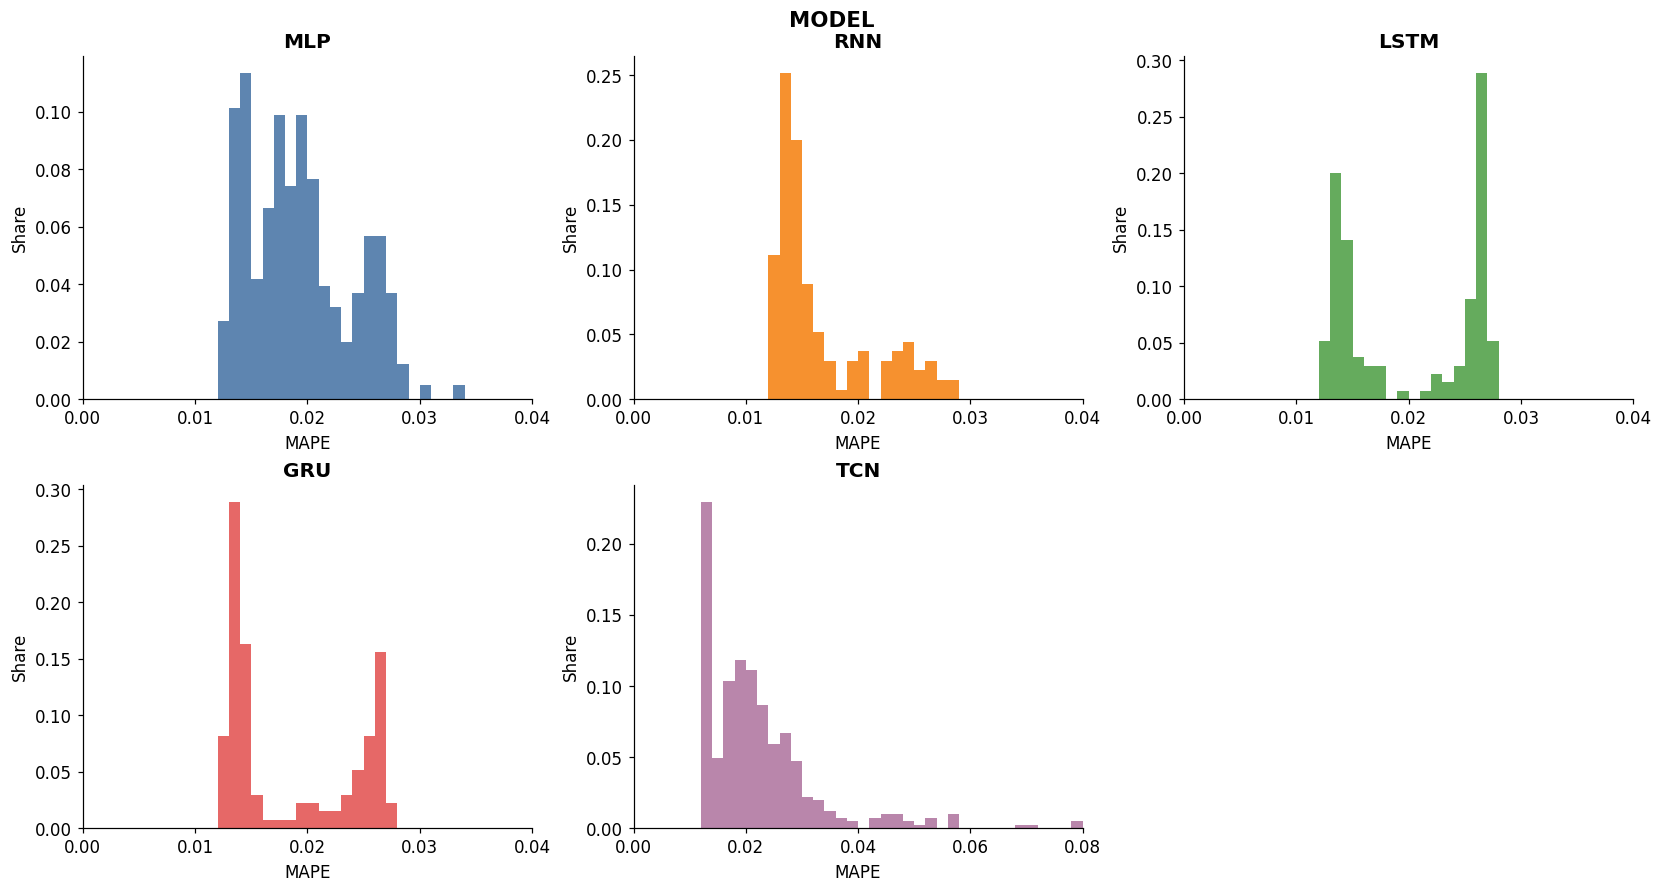

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_MLP.png


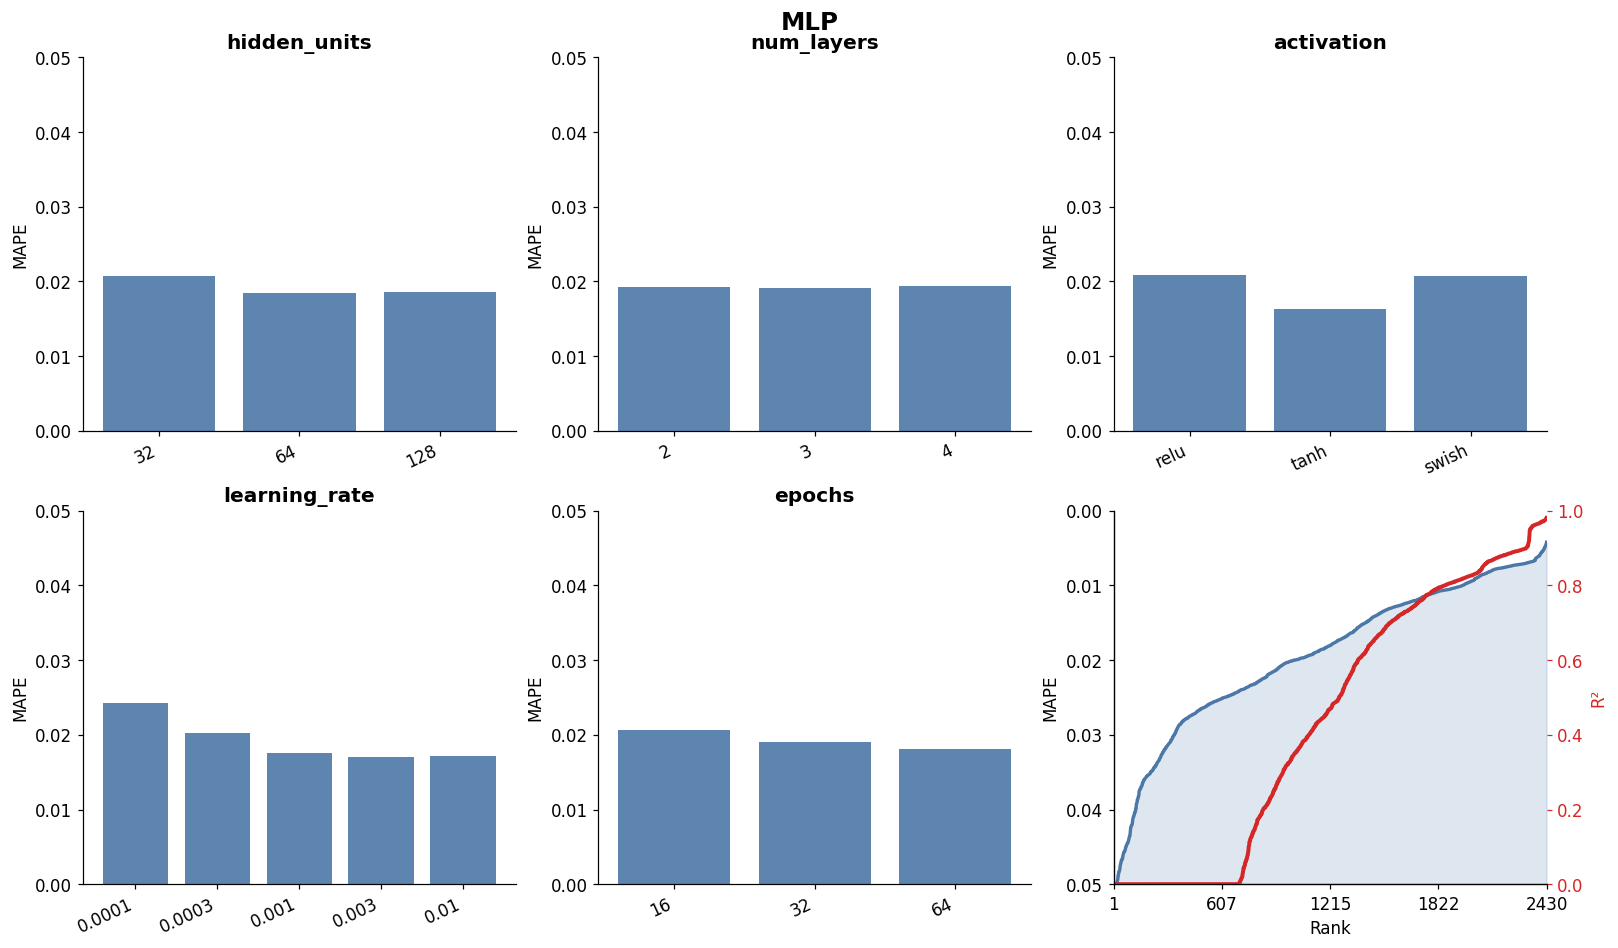

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_RNN.png


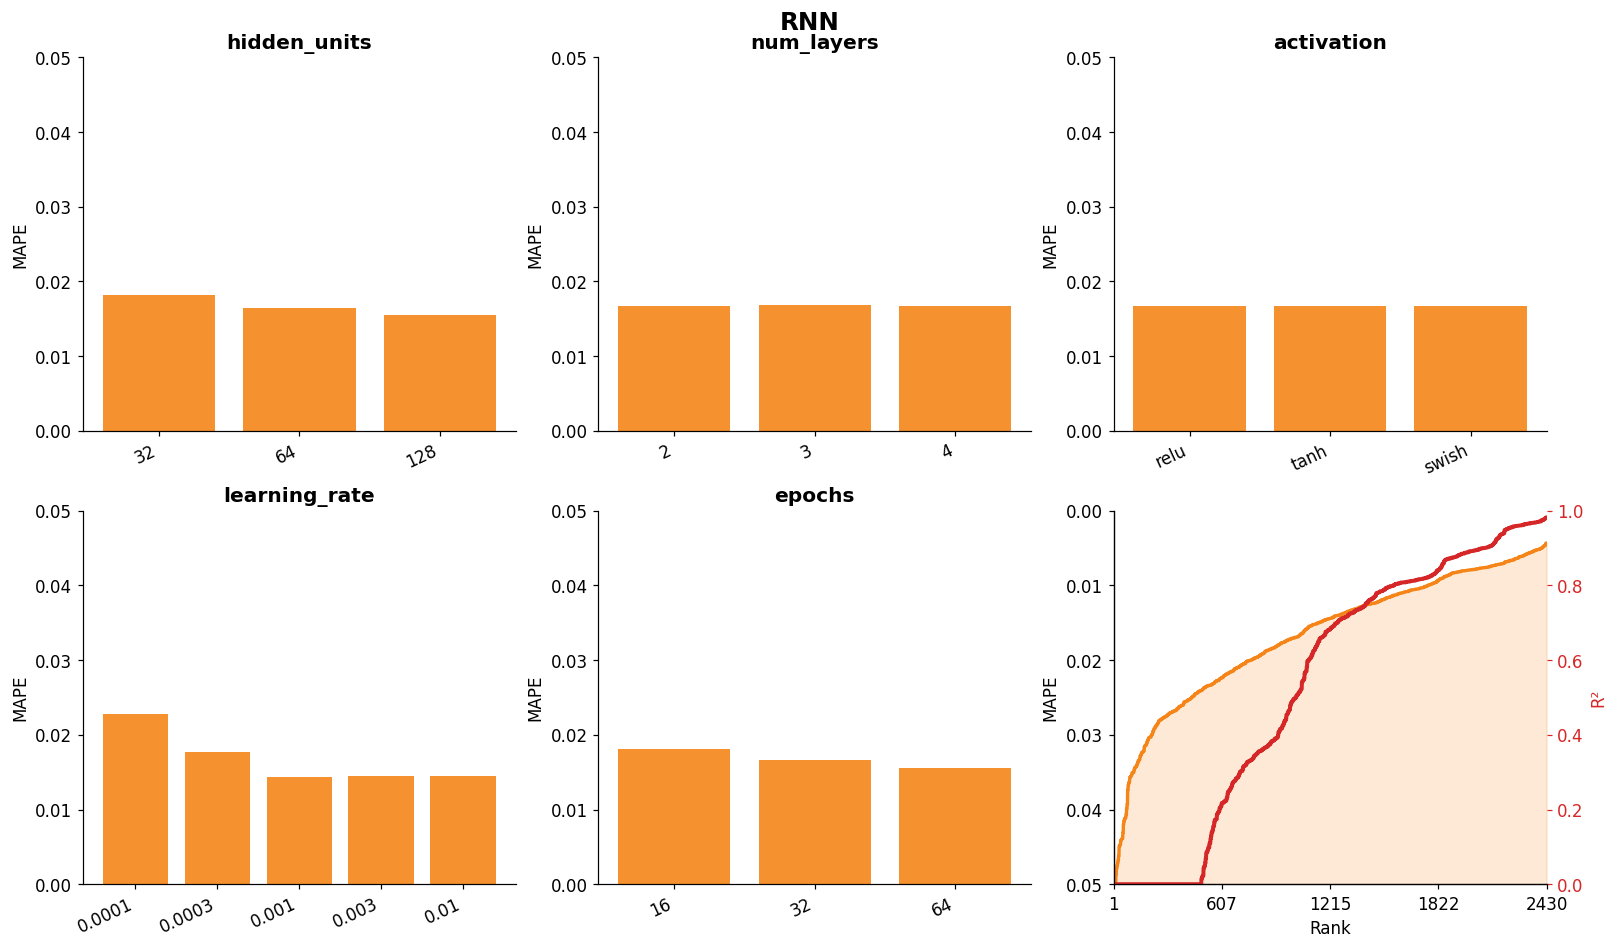

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_LSTM.png


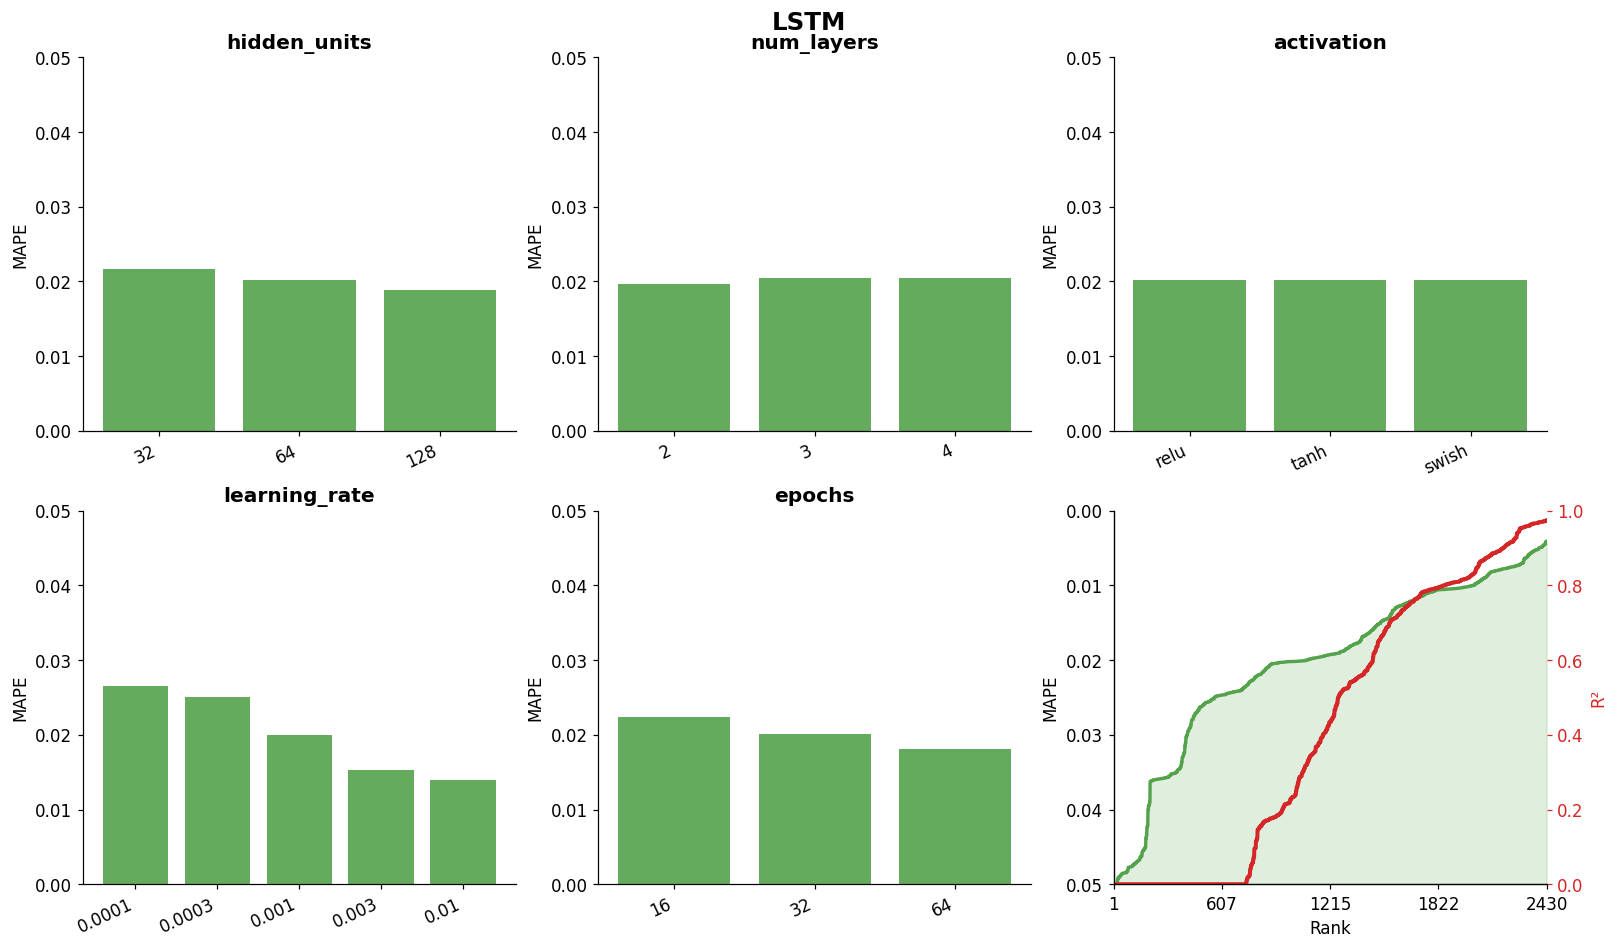

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_GRU.png


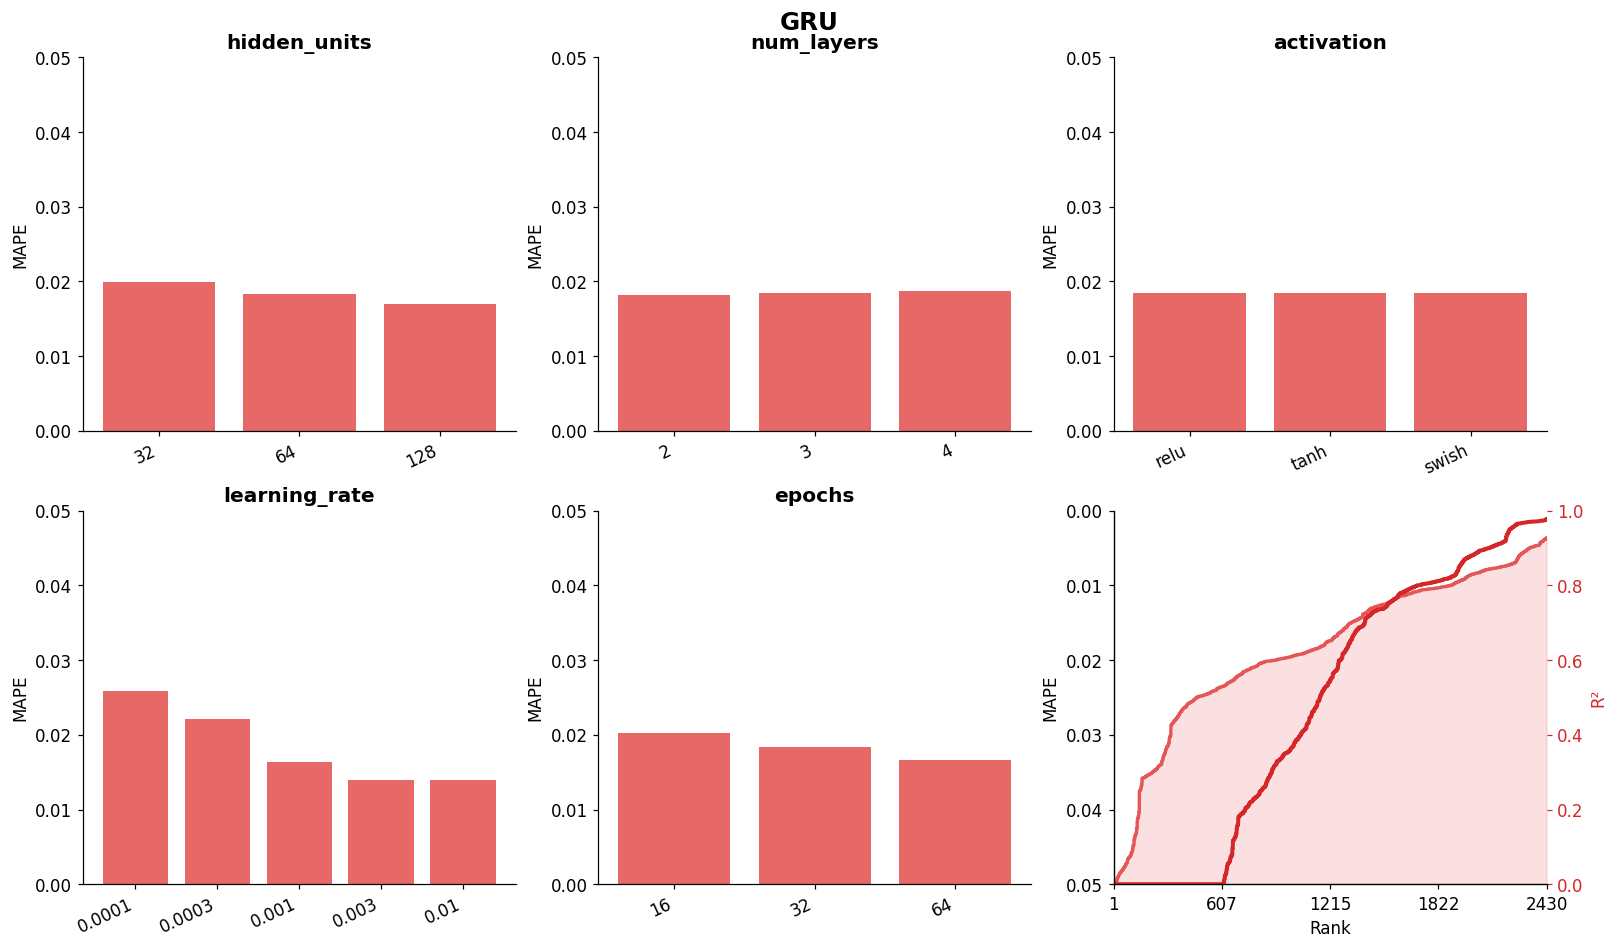

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/hp_sensitivity_TCN.png


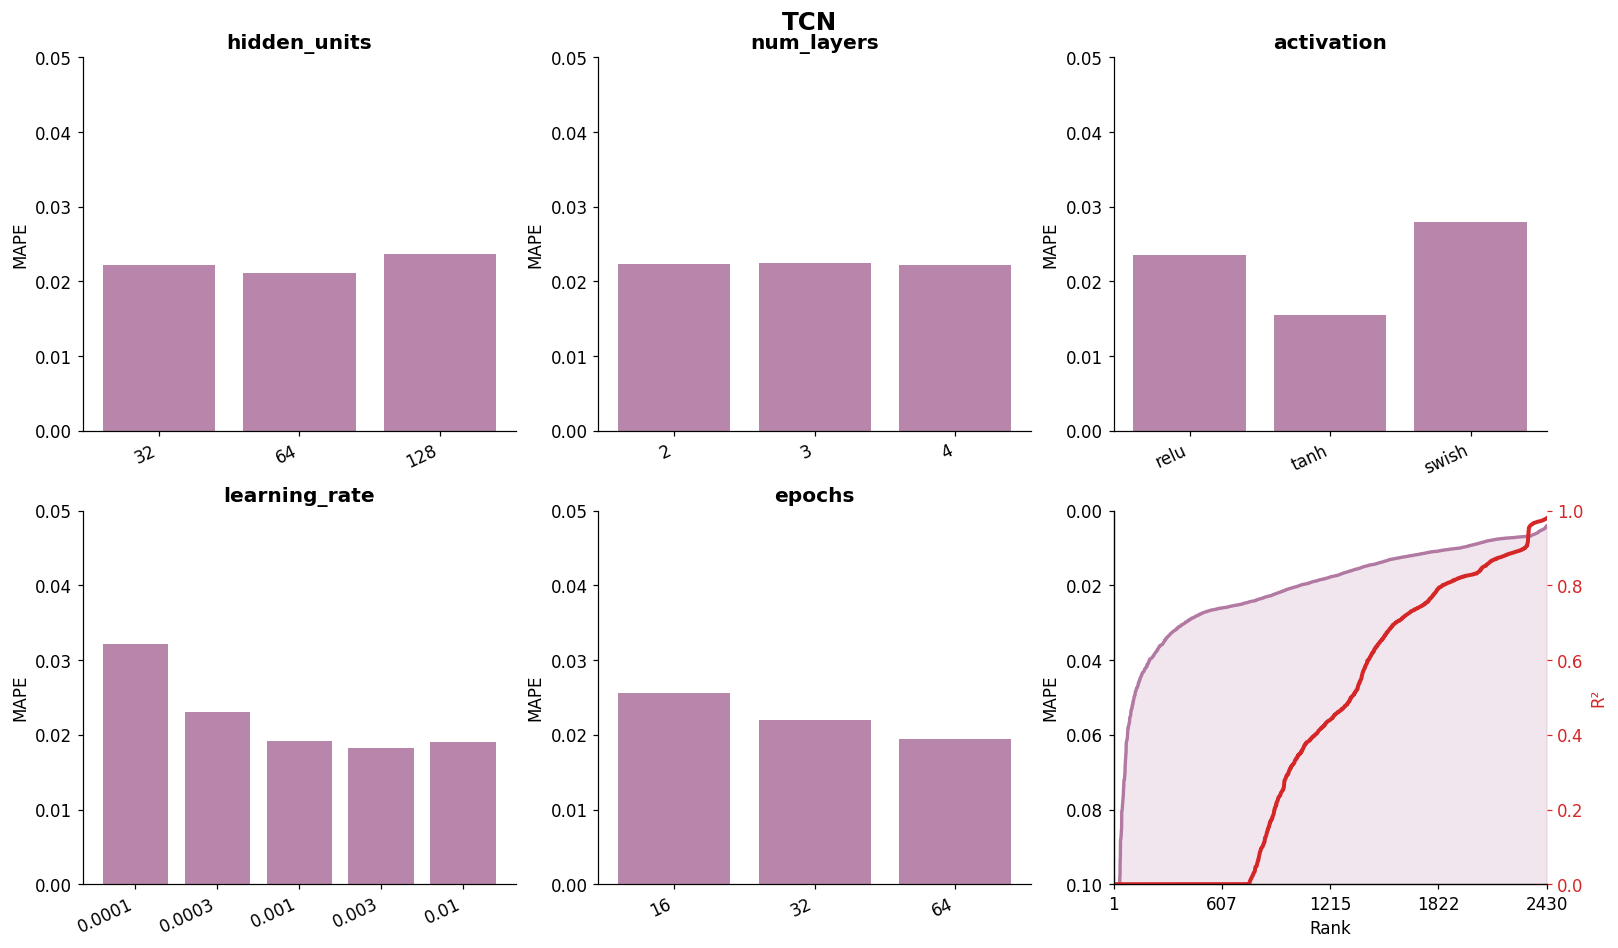

[SAVED] visualizations/co2_rigorous_pretty_gold_v4_rawpool/configs_ranked_all.csv
[DONE] Outputs saved to: visualizations/co2_rigorous_pretty_gold_v4_rawpool


In [8]:
# co2_rigorous_pretty_gold_v4_rawpool.py
from __future__ import annotations

from pathlib import Path
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
ROOT = Path(".")
RESULTS_DIR = ROOT / "results"
SCORES_PATH = RESULTS_DIR / "co2_config_scores.csv"  # required for config plots

OUT_DIR = ROOT / "visualizations" / "co2_rigorous_pretty_gold_v4_rawpool"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEFAULT_MODELS = ["MLP", "RNN", "LSTM", "GRU", "TCN"]

MARKET_ORDER = ["Australia", "California", "EU_EEX", "NewZealand", "RGGI", "Shanghai"]
MODEL_ORDER = DEFAULT_MODELS[:]  # keep consistent ordering everywhere

# Market abbreviations
MARKET_ABBR = {
    "Australia": "AU",
    "California": "US(CA)",
    "EU_EEX": "EU",
    "NewZealand": "NZ",
    "RGGI": "US(NE)",
    "Shanghai": "CN",
}

# percent-type plot caps
PCT_ERR_YMAX = 0.05

# histogram specs
HIST_BINS = 40
HIST_XMAX_NONTCN = 0.04
HIST_XMAX_TCN = 0.08

# sixth subplot axes
RANK_MAPE_CAP_NONTCN = 0.05
RANK_MAPE_CAP_TCN = 0.10

# -----------------------------
# Style
# -----------------------------
plt.rcParams.update(
    {
        "figure.dpi": 110,
        "savefig.dpi": 220,
        "axes.grid": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "semibold",
        "font.size": 11,
    }
)

MODEL_COLORS = {
    "MLP":  "#4C78A8",
    "RNN":  "#F58518",
    "LSTM": "#54A24B",
    "GRU":  "#E45756",
    "TCN":  "#B279A2",
}
DEFAULT_COLOR = "#777777"
R2_RED = "#D62728"

# -----------------------------
# Utilities
# -----------------------------
def savefig(name: str, fig: plt.Figure | None = None) -> None:
    path = OUT_DIR / name
    if fig is None:
        fig = plt.gcf()
    fig.savefig(path, dpi=220, bbox_inches="tight")
    print("[SAVED]", path)

def _is_naive(model_name: str) -> bool:
    s = str(model_name).strip().lower()
    return ("naive" in s) or (s == "naive_last_price") or (s == "naive")

def parse_hyperparams(s: str) -> dict:
    """
    Robustly parse strings like:
      "{""hidden_units"": 32, ""num_layers"": 2, ...}"
    or normal JSON, or Python dict literals.
    """
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return {}
    st = str(s).strip()
    if not st:
        return {}

    # strip outer quotes if present
    if len(st) >= 2 and ((st[0] == st[-1] == '"') or (st[0] == st[-1] == "'")):
        st = st[1:-1].strip()

    # fix doubled quotes
    st2 = st.replace('""', '"')

    for cand in (st, st2):
        try:
            obj = json.loads(cand)
            if isinstance(obj, dict):
                return obj
        except Exception:
            pass

    for cand in (st, st2):
        try:
            obj = ast.literal_eval(cand)
            if isinstance(obj, dict):
                return obj
        except Exception:
            pass

    return {}

def deep_find(d: dict, keys: list[str]):
    for k in keys:
        if k in d:
            return d.get(k)
    return np.nan

HP_ORDER = ["hidden_units", "num_layers", "activation", "learning_rate", "epochs"]

def add_standard_hp_columns(cfg: pd.DataFrame, hp_dict_col: str = "hp_dict") -> pd.DataFrame:
    cfg = cfg.copy()

    def hidden_units_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        if r["model"] == "TCN":
            return deep_find(d, ["channels", "tcn_channels", "hidden_units", "units"])
        return deep_find(d, ["hidden_units", "units"])

    def num_layers_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        if r["model"] == "TCN":
            return deep_find(d, ["blocks", "tcn_blocks", "num_layers", "layers", "depth"])
        return deep_find(d, ["num_layers", "layers", "depth"])

    def activation_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["activation", "act"])

    def lr_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["learning_rate", "lr"])

    def epochs_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["epochs", "n_epochs", "epoch"])

    cfg["hp_hidden_units"]  = cfg.apply(hidden_units_row, axis=1)
    cfg["hp_num_layers"]    = cfg.apply(num_layers_row, axis=1)
    cfg["hp_activation"]    = cfg.apply(activation_row, axis=1)
    cfg["hp_learning_rate"] = cfg.apply(lr_row, axis=1)
    cfg["hp_epochs"]        = cfg.apply(epochs_row, axis=1)
    return cfg

# -----------------------------
# Heatmaps: best-by-MAPE and best-by-R2 (computed from raw per-market-config rows)
# -----------------------------
def _heatmap(ax, mat: np.ndarray, xlabels: list[str], ylabels: list[str], *, vmin=None, vmax=None, fmt="{:.3f}"):
    im = ax.imshow(mat, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels)
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels)

    # annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            if np.isfinite(val):
                ax.text(j, i, fmt.format(val), ha="center", va="center", fontsize=9)

    return im

def plot_best_config_heatmaps(cfg_market: pd.DataFrame, markets: list[str], models: list[str]) -> None:
    """
    Uses cfg_market (one row per market-model-config).
    Produces:
      1) MAPE best (min over configs) heatmap
      2) R² at MAPE-best heatmap (same configs as #1)
      3) R² best (max over configs) heatmap
    """
    sub = cfg_market[cfg_market["model"].isin(models)].copy()
    sub = sub[sub["market"].isin(markets)].copy()

    # best by MAPE
    best_m = sub.loc[sub.groupby(["market", "model"])["MAPE"].idxmin()].copy()
    piv_mape = best_m.pivot(index="market", columns="model", values="MAPE").reindex(index=markets, columns=models)
    piv_r2_at_bestm = best_m.pivot(index="market", columns="model", values="R2").reindex(index=markets, columns=models)

    # best by R2
    best_r = sub.loc[sub.groupby(["market", "model"])["R2"].idxmax()].copy()
    piv_best_r2 = best_r.pivot(index="market", columns="model", values="R2").reindex(index=markets, columns=models)

    ylabels = [MARKET_ABBR.get(m, m) for m in markets]

    # 1) MAPE best
    fig, ax = plt.subplots(1, 1, figsize=(10.8, 3.6), constrained_layout=True)
    im = _heatmap(
        ax,
        piv_mape.values.astype(float),
        models,
        ylabels,
        vmin=0.0,
        vmax=0.025,               # tight range (best configs are <~0.023 in your file)
        fmt="{:.4f}",
    )
    ax.set_title("MAPE")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("MAPE")
    savefig("heatmap_best_MAPE.png", fig=fig)
    plt.show()
    plt.close(fig)

    # 2) R2 at MAPE best
    fig, ax = plt.subplots(1, 1, figsize=(10.8, 3.6), constrained_layout=True)
    im = _heatmap(
        ax,
        piv_r2_at_bestm.values.astype(float),
        models,
        ylabels,
        vmin=-0.1,
        vmax=1.0,
        fmt="{:.3f}",
    )
    ax.set_title("R² (at MAPE-best)")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("R²")
    savefig("heatmap_R2_at_best_MAPE.png", fig=fig)
    plt.show()
    plt.close(fig)

    # 3) Best R2
    fig, ax = plt.subplots(1, 1, figsize=(10.8, 3.6), constrained_layout=True)
    im = _heatmap(
        ax,
        piv_best_r2.values.astype(float),
        models,
        ylabels,
        vmin=0.0,
        vmax=1.0,
        fmt="{:.3f}",
    )
    ax.set_title("R²")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("R²")
    savefig("heatmap_best_R2.png", fig=fig)
    plt.show()
    plt.close(fig)

# -----------------------------
# Histogram panel: per-config mean across markets (each config counts once)
# -----------------------------
def plot_cfg_hist_panel(cfg_overall: pd.DataFrame, models: list[str]) -> None:
    """
    Histogram panel:
      - non-TCN: x in [0, 0.04], 40 bins
      - TCN: x in [0, 0.08], 40 bins
    y-axis: share per bin = count / n_configs
    """
    n = len(models)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.0 * ncols, 3.9 * nrows), constrained_layout=True)
    axes = np.array(axes).ravel()

    for ax, m in zip(axes, models):
        sub = cfg_overall[cfg_overall["model"] == m].copy()
        vals = sub["mean_MAPE"].astype(float).values
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{m}", ha="center", va="center")
            continue

        x_max = HIST_XMAX_TCN if m == "TCN" else HIST_XMAX_NONTCN
        edges = np.linspace(0.0, x_max, HIST_BINS + 1)

        vals = np.clip(vals, 0.0, x_max)
        weights = np.ones_like(vals) / max(1, vals.size)  # share per bin

        ax.hist(vals, bins=edges, weights=weights, alpha=0.9,
                color=MODEL_COLORS.get(m, DEFAULT_COLOR))
        ax.set_title(m)
        ax.set_xlabel("MAPE")
        ax.set_ylabel("Share")
        ax.set_xlim(0.0, x_max)
        ax.set_xticks(np.linspace(0.0, x_max, 5))

    for k in range(len(models), len(axes)):
        axes[k].axis("off")

    fig.suptitle("MODEL", y=1.02, fontsize=14, fontweight="semibold")
    savefig("panel_hist_config_MAPE.png", fig=fig)
    plt.show()
    plt.close(fig)

# -----------------------------
# HP sensitivity (2x3) per model
# -----------------------------
def plot_hp_sensitivity_panel(cfg_overall: pd.DataFrame, cfg_market: pd.DataFrame, model: str) -> None:
    """
    2x3 grid
    First five: mean MAPE by HP value (from cfg_overall; each config counted once).
    Sixth: RAW POOLING across markets (405 configs * 6 markets = 2430 points typically):
        Pool all (market, config) rows for this model,
        then sort independently:
          MAPE: worst -> best (descending)  [left axis, inverted]
          R2:   worst -> best (ascending)   [right axis, 0..1]
    """
    sub = cfg_overall[cfg_overall["model"] == model].copy()
    if sub.empty:
        return

    fig, axes = plt.subplots(2, 3, figsize=(14.6, 8.3), constrained_layout=True)
    axes = np.array(axes).ravel()

    hp_map = {
        "hidden_units": "hp_hidden_units",
        "num_layers": "hp_num_layers",
        "activation": "hp_activation",
        "learning_rate": "hp_learning_rate",
        "epochs": "hp_epochs",
    }

    # First five
    for i, hp_name in enumerate(HP_ORDER):
        ax = axes[i]
        col = hp_map[hp_name]
        if col not in sub.columns or sub[col].dropna().empty:
            ax.axis("off")
            ax.text(0.5, 0.5, hp_name, ha="center", va="center", fontsize=12, color="#444444")
            continue

        g = sub.groupby(col, dropna=True)["mean_MAPE"].mean().reset_index()
        if g.shape[0] < 2:
            ax.axis("off")
            ax.text(0.5, 0.5, hp_name, ha="center", va="center", fontsize=12, color="#444444")
            continue

        # stable ordering
        if hp_name in ("hidden_units", "num_layers", "epochs", "learning_rate"):
            try:
                g["_k"] = g[col].astype(float)
                g = g.sort_values("_k").drop(columns="_k")
            except Exception:
                g[col] = g[col].astype(str)
                g = g.sort_values(col)
        else:
            order = ["relu", "tanh", "swish"]
            g[col] = g[col].astype(str)
            g["_k"] = g[col].map({v: j for j, v in enumerate(order)}).fillna(999).astype(int)
            g = g.sort_values("_k").drop(columns="_k")

        x = np.arange(len(g))
        ax.bar(x, g["mean_MAPE"].values, color=MODEL_COLORS.get(model, DEFAULT_COLOR), alpha=0.9)
        ax.set_xticks(x)
        ax.set_xticklabels(g[col].astype(str).values, rotation=25, ha="right")
        ax.set_title(hp_name)
        ax.set_ylabel("MAPE")
        ax.set_ylim(0.0, PCT_ERR_YMAX)

    # Sixth: pooled ranks
    ax = axes[5]
    subm = cfg_market[cfg_market["model"] == model].copy()
    subm = subm[np.isfinite(subm["MAPE"].astype(float)) & np.isfinite(subm["R2"].astype(float))].copy()

    if subm.empty:
        ax.axis("off")
        fig.suptitle(model, y=1.02, fontsize=16, fontweight="semibold")
        savefig(f"hp_sensitivity_{model}.png", fig=fig)
        plt.show()
        plt.close(fig)
        return

    mvals = subm["MAPE"].astype(float).values
    rvals = subm["R2"].astype(float).values

    y_m = np.sort(mvals)[::-1]   # MAPE worst -> best
    y_r = np.sort(rvals)         # R2   worst -> best

    L = int(min(y_m.size, y_r.size))
    y_m = y_m[:L]
    y_r = y_r[:L]
    x = np.arange(1, L + 1)

    mape_cap = RANK_MAPE_CAP_TCN if model == "TCN" else RANK_MAPE_CAP_NONTCN
    y_m_clip = np.clip(y_m, 0.0, mape_cap)
    y_r_clip = np.clip(y_r, 0.0, 1.0)

    ax.plot(x, y_m_clip, linewidth=2.2, color=MODEL_COLORS.get(model, DEFAULT_COLOR))
    ax.fill_between(x, y_m_clip, y2=mape_cap, alpha=0.18, color=MODEL_COLORS.get(model, DEFAULT_COLOR))
    ax.set_xlabel("Rank")
    ax.set_ylabel("MAPE")
    ax.set_xlim(1, L)
    ax.set_ylim(0.0, mape_cap)
    ax.invert_yaxis()
    ax.set_xticks([1, int(L * 0.25), int(L * 0.5), int(L * 0.75), L])

    ax2 = ax.twinx()
    ax2.plot(x, y_r_clip, linewidth=2.6, color=R2_RED)
    ax2.set_ylabel("R²", color=R2_RED)
    ax2.tick_params(axis="y", colors=R2_RED)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_yticks(np.linspace(0.0, 1.0, 6))

    fig.suptitle(model, y=1.02, fontsize=16, fontweight="semibold")
    savefig(f"hp_sensitivity_{model}.png", fig=fig)
    plt.show()
    plt.close(fig)

# =============================================================================
# MAIN
# =============================================================================
def main() -> None:
    scores_path = SCORES_PATH
    if not scores_path.exists():
        alt = Path("/mnt/data/co2_config_scores.csv")
        if alt.exists():
            scores_path = alt
        else:
            raise FileNotFoundError(f"Missing {SCORES_PATH}")

    scores = pd.read_csv(scores_path)

    scores["model"] = scores["model"].astype(str).str.upper()

    # detect hyperparam column robustly
    hyper_col = None
    for cand in ["hyperparams_json", "model_hyperparameters_dict", "model_hyperparameters", "hyperparams", "config_json"]:
        if cand in scores.columns:
            hyper_col = cand
            break
    if hyper_col is None:
        raise ValueError("No hyperparameter JSON column found in co2_config_scores.csv")

    # drop naive for config analysis
    scores = scores[~scores["model"].map(_is_naive)].copy()
    scores["hp_dict"] = scores[hyper_col].map(parse_hyperparams)

    # cfg_market: one row per (market, model, config)
    cfg_market = (
        scores.groupby(["market", "model", hyper_col], as_index=False)
              .agg(
                  MAPE=("MAPE", "mean"),
                  R2=("R2", "mean"),
              )
    )
    cfg_market["market_abbr"] = cfg_market["market"].map(lambda x: MARKET_ABBR.get(x, x))

    # cfg_overall: one row per (model, config), averaged across markets
    cfg_overall = (
        cfg_market.groupby(["model", hyper_col], as_index=False)
                  .agg(
                      mean_MAPE=("MAPE", "mean"),
                      mean_R2=("R2", "mean"),
                      markets_covered=("market", "nunique"),
                  )
    )

    # attach hp_dict and standardize HP columns
    cfg_hp = scores.drop_duplicates(subset=["model", hyper_col], keep="first")[["model", hyper_col, "hp_dict"]]
    cfg_overall = cfg_overall.merge(cfg_hp, on=["model", hyper_col], how="left")
    cfg_overall = add_standard_hp_columns(cfg_overall, hp_dict_col="hp_dict")

    # models present (preferred order)
    cfg_models = [m for m in MODEL_ORDER if m in sorted(cfg_overall["model"].unique())]
    if not cfg_models:
        cfg_models = sorted(cfg_overall["model"].unique().tolist())

    markets_present = [m for m in MARKET_ORDER if m in set(cfg_market["market"].unique())]
    if not markets_present:
        markets_present = sorted(cfg_market["market"].unique().tolist())

    print("[INFO] scores rows:", scores.shape[0])
    print("[INFO] markets:", [MARKET_ABBR.get(m, m) for m in markets_present])
    print("[INFO] models:", cfg_models)
    print("[INFO] unique configs:", cfg_overall.shape[0])
    print("[INFO] cfg_market rows (market-model-config):", cfg_market.shape[0])
    print("[INFO] Output dir:", OUT_DIR)

    # (A) Heatmaps (best configs per market-model)
    plot_best_config_heatmaps(cfg_market, markets_present, cfg_models)

    # (B) Histogram panel (per-config mean across markets)
    plot_cfg_hist_panel(cfg_overall, cfg_models)

    # (C) HP sensitivity per model (subplot #6 uses pooled raw market rows)
    for m in cfg_models:
        plot_hp_sensitivity_panel(cfg_overall, cfg_market, m)

    # (D) Save full ranked config table
    ranked_all = (
        cfg_overall.sort_values(["model", "markets_covered", "mean_MAPE", "mean_R2"],
                                ascending=[True, False, True, False])
                  .reset_index(drop=True)
    )
    out_csv = OUT_DIR / "configs_ranked_all.csv"
    ranked_all.to_csv(out_csv, index=False)
    print("[SAVED]", out_csv)
    print("[DONE] Outputs saved to:", OUT_DIR)

if __name__ == "__main__":
    main()



Gold market×model metrics (MAPE/R2 are chunk-averaged; *_raw are full-series)


,MAPE_raw,R2_raw,RMSE_over_mean_price_raw,MAPE,R2,RMSE_over_mean_price,market,model,n_points,market_abbr
4,0.009922,0.960272,0.015230,0.009922,0.947135,0.014995,Australia,TCN,750,AU
3,0.010471,0.959494,0.015379,0.010471,0.944407,0.015205,Australia,GRU,750,AU
2,0.010515,0.956681,0.015904,0.010515,0.941873,0.015671,Australia,LSTM,750,AU
0,0.010785,0.955591,0.016102,0.010785,0.939148,0.015905,Australia,MLP,750,AU
1,0.010872,0.954371,0.016322,0.010872,0.942474,0.015958,Australia,RNN,750,AU
7,0.009868,0.988953,0.014716,0.009868,0.966627,0.014376,California,LSTM,750,US(CA)
8,0.009925,0.989187,0.014560,0.009925,0.967784,0.014160,California,GRU,750,US(CA)
6,0.010342,0.988563,0.014974,0.010342,0.965904,0.014704,California,RNN,750,US(CA)
9,0.010642,0.986987,0.015972,0.010642,0.960655,0.015738,California,TCN,750,US(CA)
5,0.010768,0.986038,0.016544,0.010768,0.959682,0.016242,California,MLP,750,US(CA)



Ranking (gold)


,market_abbr,rank_in_market,model,MAPE,RMSE_over_mean_price,R2,n_points
4,AU,1,TCN,0.009922,0.014995,0.947135,750
3,AU,2,GRU,0.010471,0.015205,0.944407,750
2,AU,3,LSTM,0.010515,0.015671,0.941873,750
0,AU,4,MLP,0.010785,0.015905,0.939148,750
1,AU,5,RNN,0.010872,0.015958,0.942474,750
7,US(CA),1,LSTM,0.009868,0.014376,0.966627,750
8,US(CA),2,GRU,0.009925,0.014160,0.967784,750
6,US(CA),3,RNN,0.010342,0.014704,0.965904,750
9,US(CA),4,TCN,0.010642,0.015738,0.960655,750
5,US(CA),5,MLP,0.010768,0.016242,0.959682,750



Summary by model (gold)


,model,markets_covered,mean_MAPE,median_MAPE,mean_R2,median_R2
0,GRU,6,0.014084,0.014301,0.931538,0.940449
1,LSTM,6,0.014484,0.015081,0.929095,0.939820
2,RNN,6,0.014625,0.014953,0.928400,0.939228
3,TCN,6,0.014670,0.015550,0.925155,0.945127
4,MLP,6,0.015079,0.015646,0.921192,0.934961


[SAVED] visualizations/co2_rigorous_pretty_gold_v2/panel_heatmaps.png


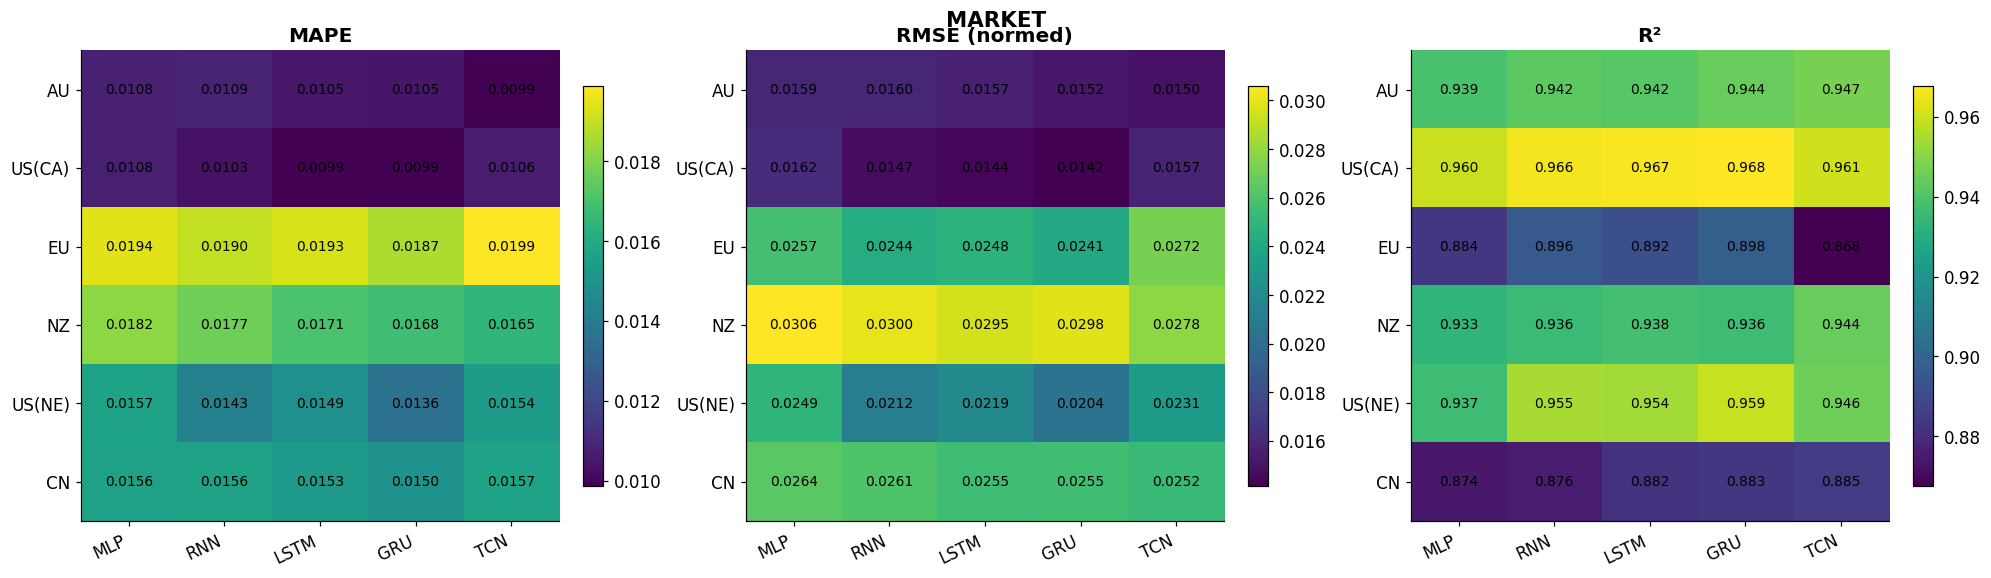

[INFO] rows in scores: 12150
[INFO] unique configs: 2025
[INFO] models: ['MLP', 'RNN', 'LSTM', 'GRU', 'TCN']
[INFO] Output dir: visualizations/co2_rigorous_pretty_gold_v2
[SAVED] visualizations/co2_rigorous_pretty_gold_v2/panel_hist_config_MAPE.png


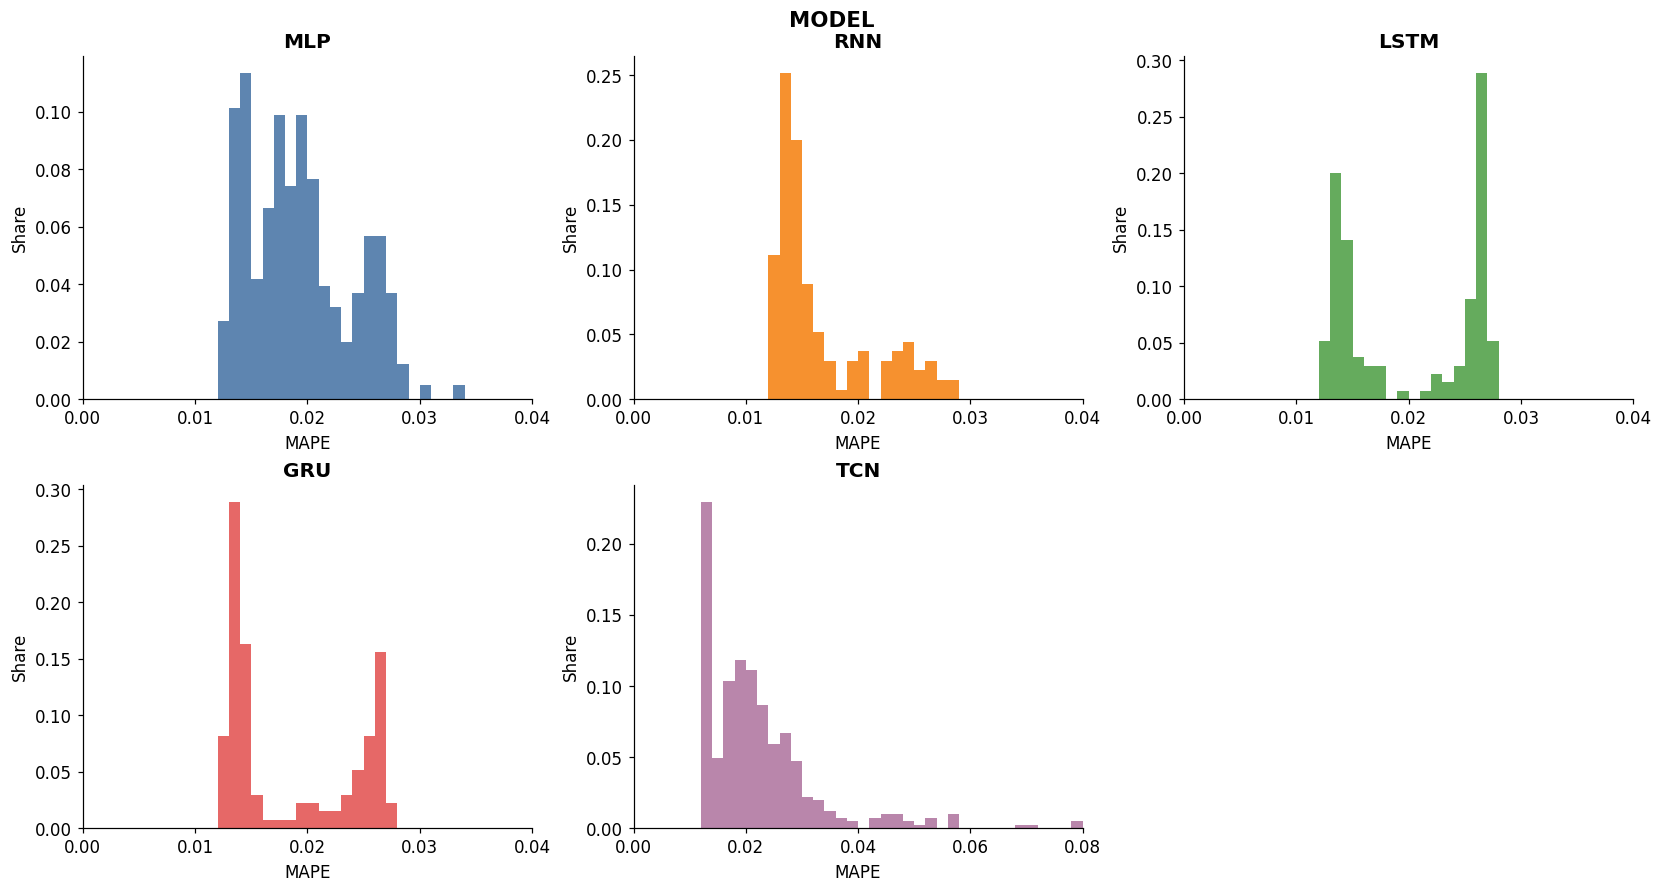

[SAVED] visualizations/co2_rigorous_pretty_gold_v2/hp_sensitivity_MLP.png


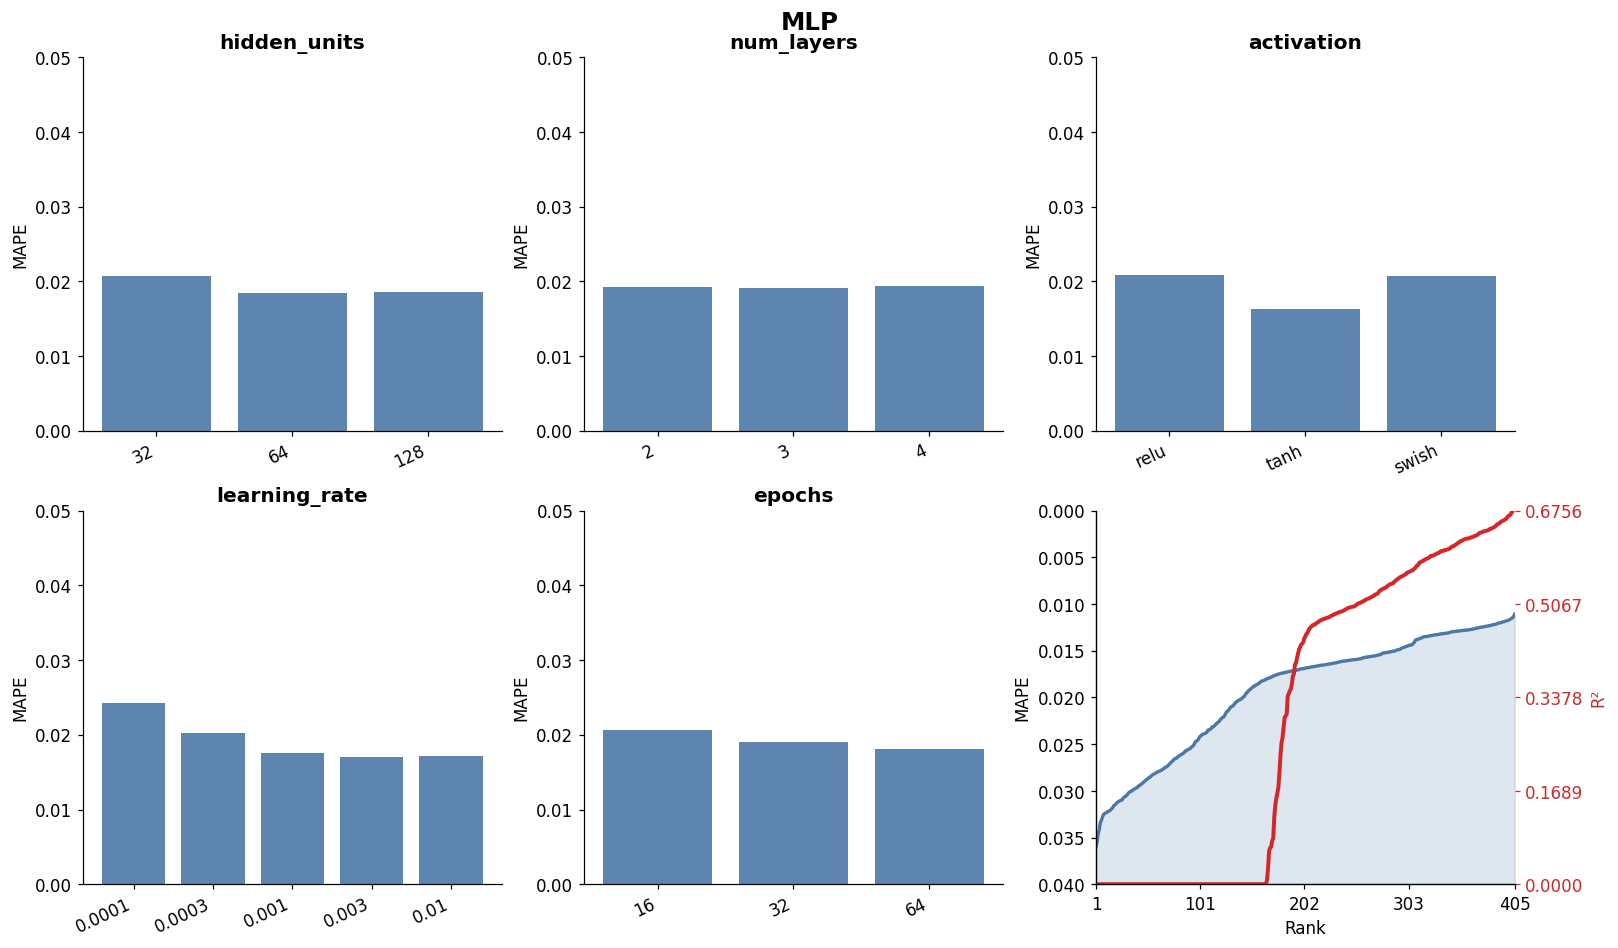

[SAVED] visualizations/co2_rigorous_pretty_gold_v2/hp_sensitivity_RNN.png


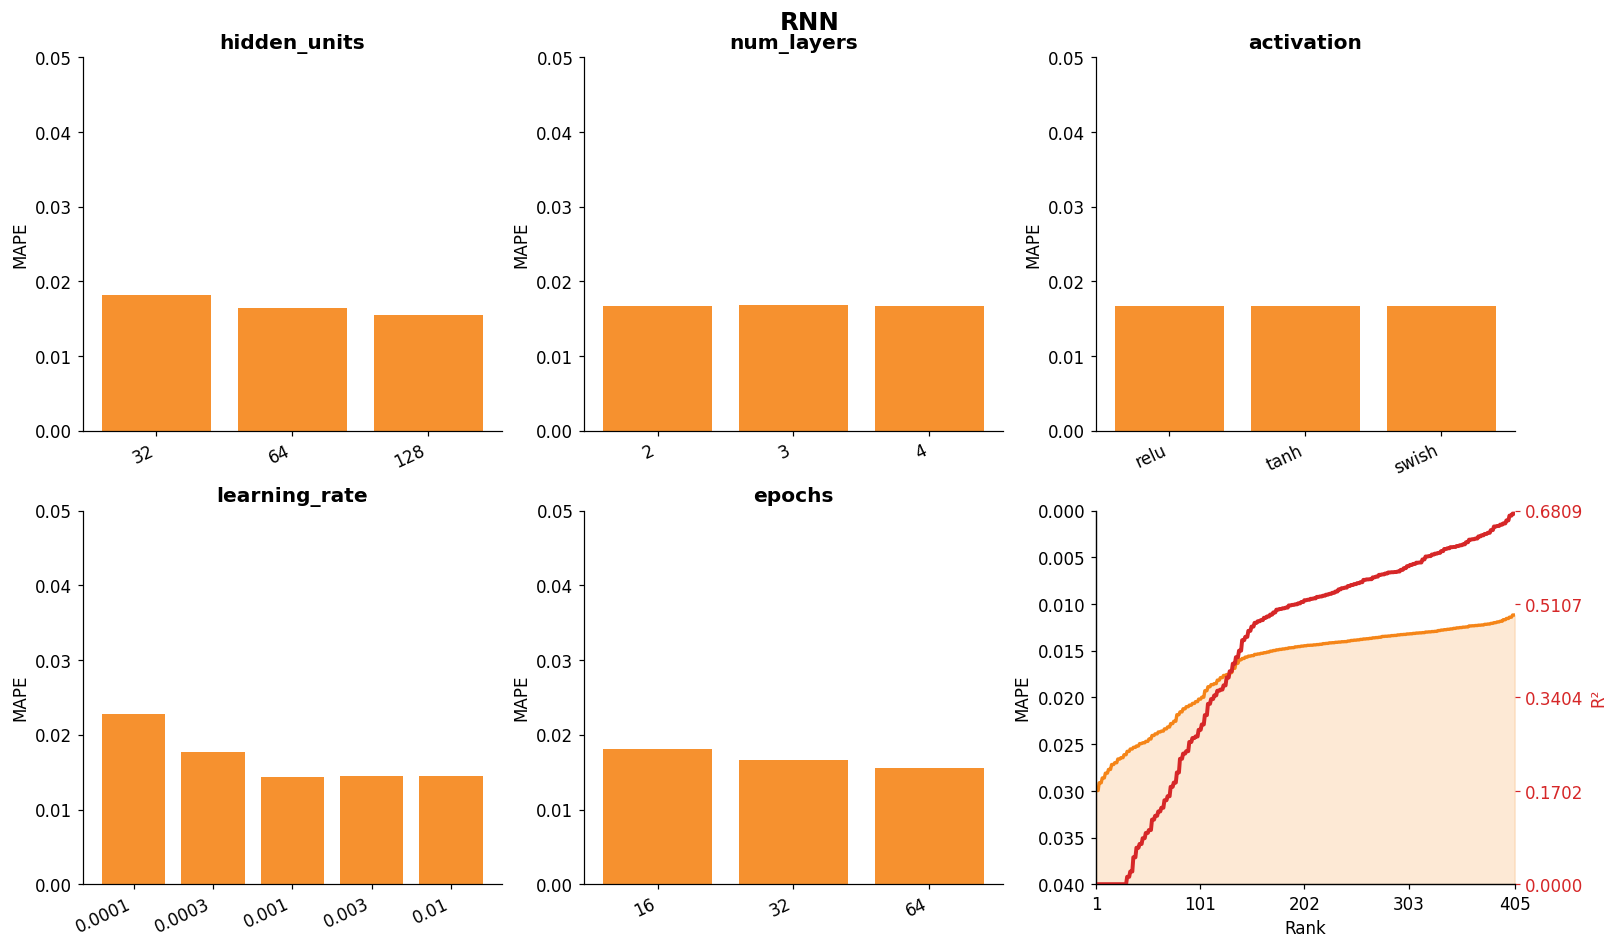

[SAVED] visualizations/co2_rigorous_pretty_gold_v2/hp_sensitivity_LSTM.png


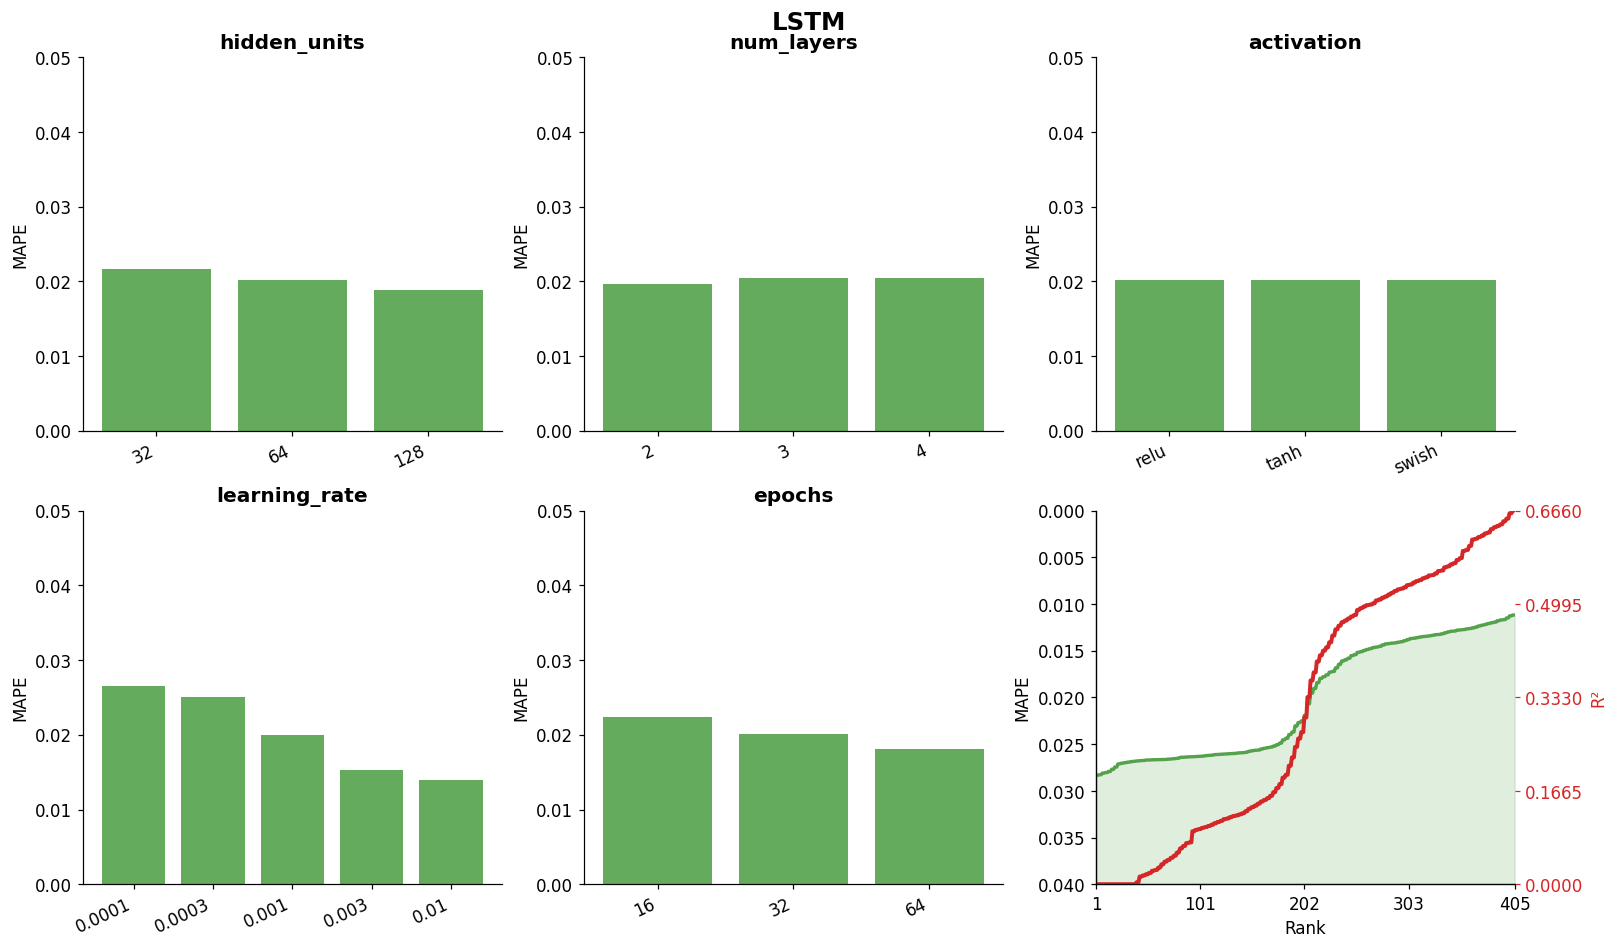

[SAVED] visualizations/co2_rigorous_pretty_gold_v2/hp_sensitivity_GRU.png


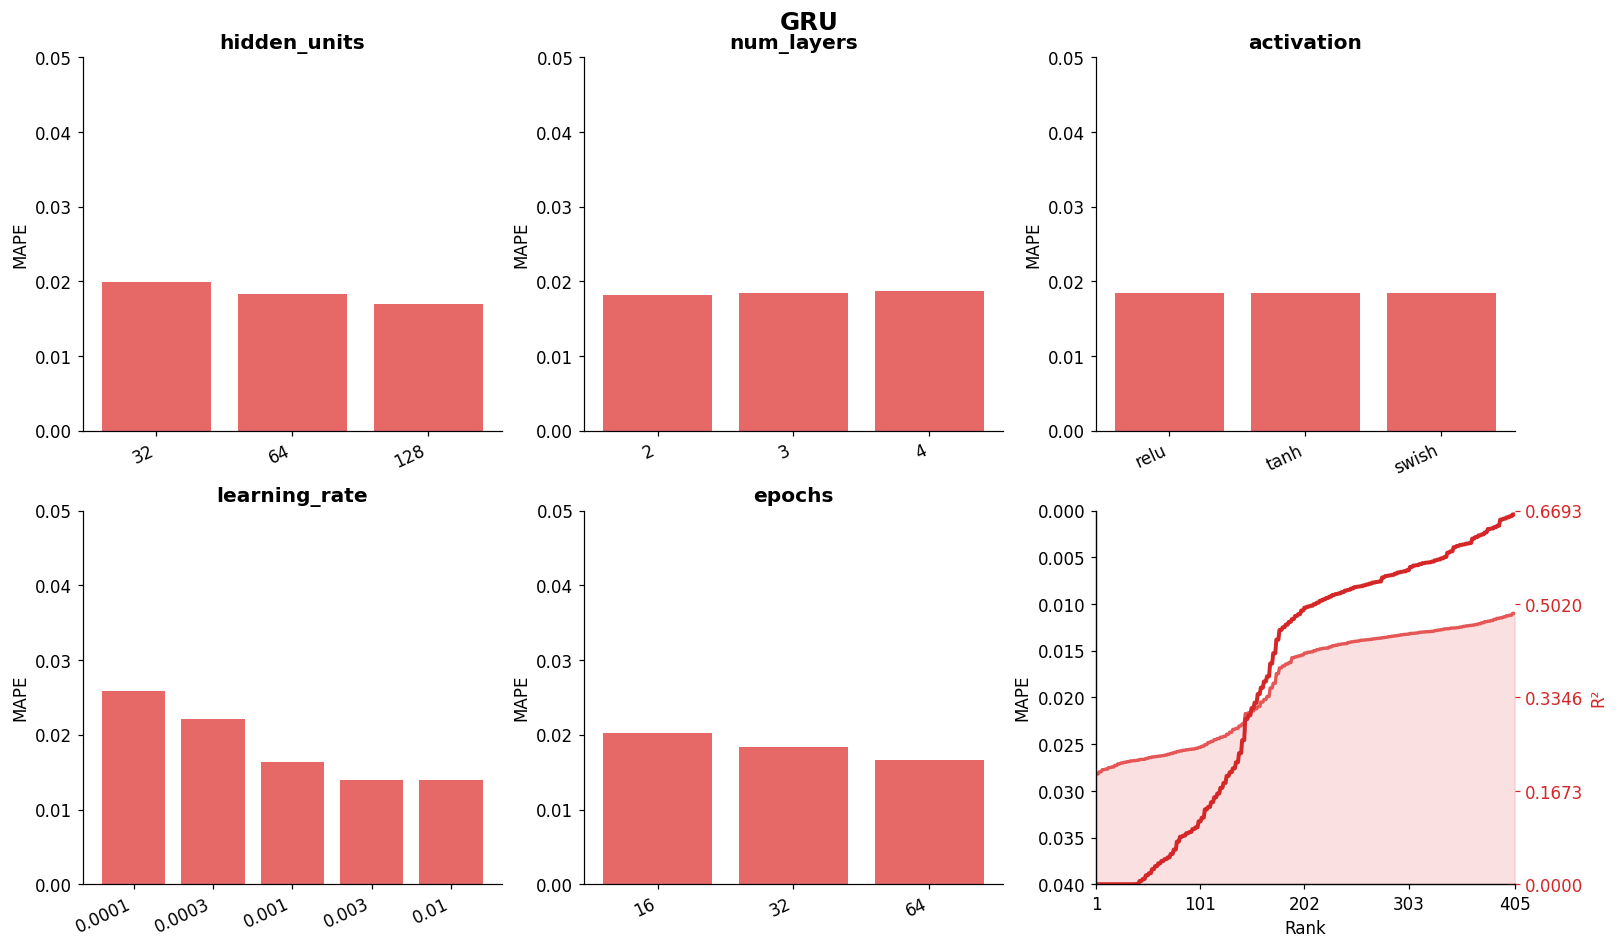

[SAVED] visualizations/co2_rigorous_pretty_gold_v2/hp_sensitivity_TCN.png


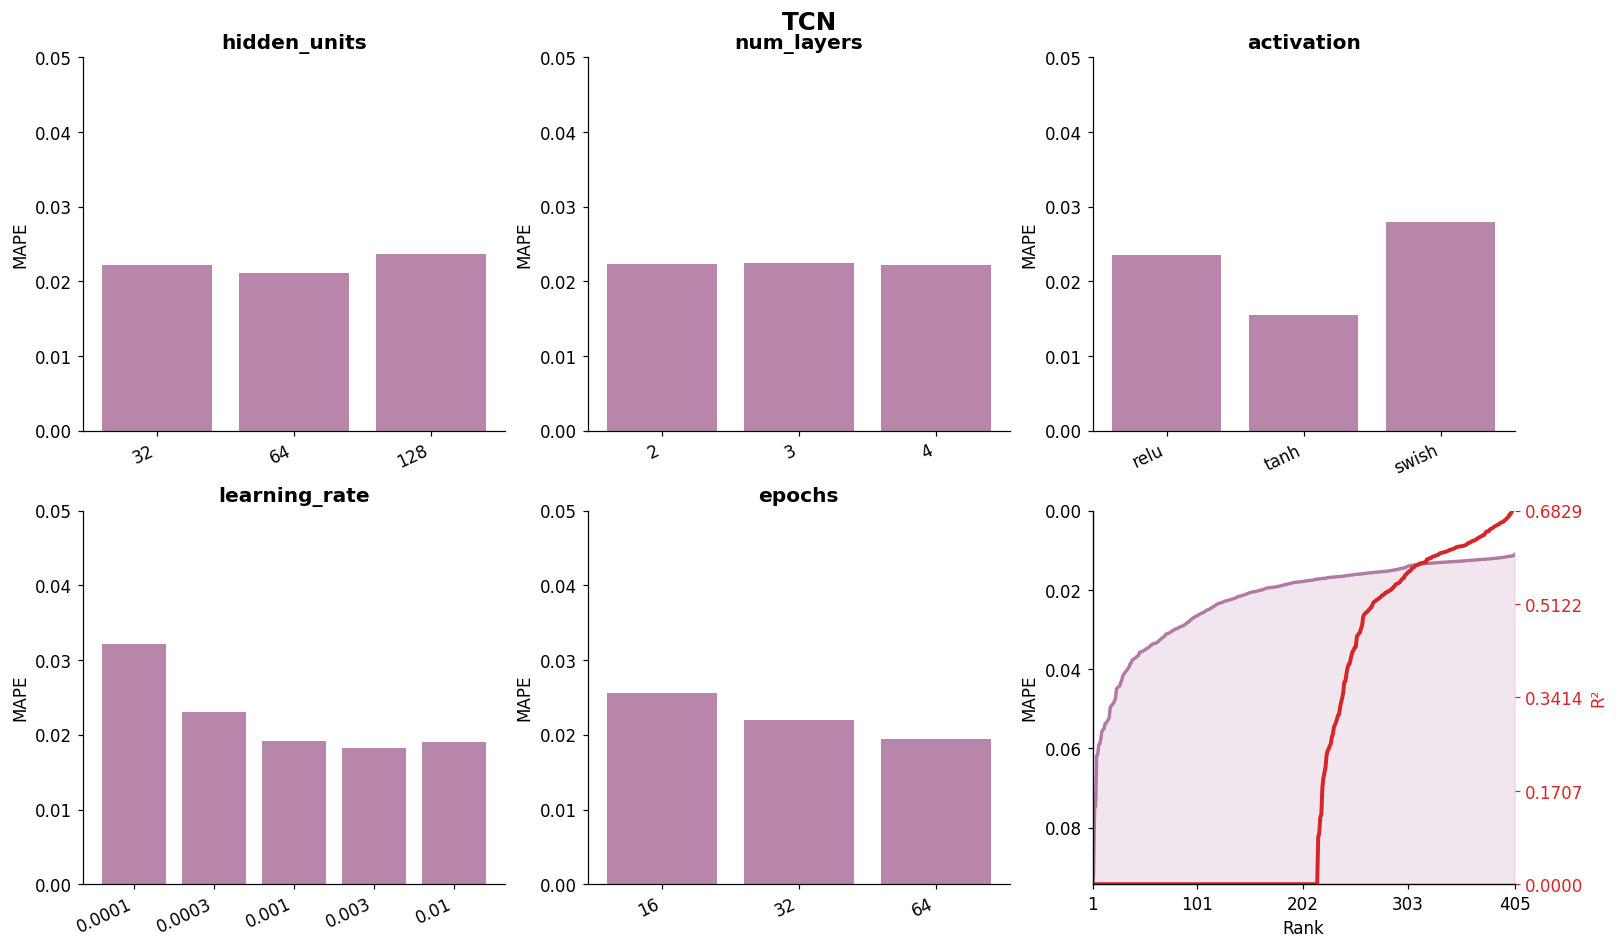

[SAVED] visualizations/co2_rigorous_pretty_gold_v2/configs_ranked_all.csv
[DONE] Outputs saved to: visualizations/co2_rigorous_pretty_gold_v2


In [11]:
# co2_rigorous_pretty_gold_v2.py
"""
CO₂ forecasting — rigorous + prettier visuals (NO NAIVE)

Gold market×model metrics (heatmaps + rankings) are computed from traces:
- concatenate window truths/preds for (market, model)
- split into 3 equal contiguous chunks
- compute metrics per chunk, then average => "gold" MAPE/R2/RMSE(normed)
- full-series metrics saved as *_raw

Config analysis uses results/co2_config_scores.csv:
- hyperparams parsed robustly (handles doubled quotes)
- histogram: share-per-bin, fixed ranges (0–0.04 non-TCN; 0–0.08 TCN)
- hp sensitivity (2×3) per model:
    first 5 subplots: mean MAPE by standardized hyperparam value (configs are unit)
    6th subplot: market-wise rank curves averaged across markets
        - for each market: sort configs separately (MAPE worst→best; R² worst→best)
        - average across markets at each rank
"""

from __future__ import annotations

from pathlib import Path
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# Config
# -----------------------------
ROOT = Path(".")
RESULTS_DIR = ROOT / "results"
TEST_LOG_DIR = ROOT / "test_log" / "co2"

SCORES_PATH = RESULTS_DIR / "co2_config_scores.csv"  # required for config plots

OUT_DIR = ROOT / "visualizations" / "co2_rigorous_pretty_gold_v2"
OUT_DIR.mkdir(parents=True, exist_ok=True)

EPS = 1e-12

# percent-type error plot caps (keep plots readable)
PCT_ERR_YMAX = 0.05

# histogram bin specs
HIST_BINS = 40
HIST_XMAX_NONTCN = 0.04
HIST_XMAX_TCN = 0.08

# rank-curve: use all configs unless you cap here
TOPK_CONFIG_CURVE = 10_000  # effectively "all"


# -----------------------------
# Market abbreviations
# -----------------------------
MARKET_ABBR = {
    "Australia": "AU",
    "California": "US(CA)",
    "EU_EEX": "EU",
    "NewZealand": "NZ",
    "RGGI": "US(NE)",
    "Shanghai": "CN",
}
DEFAULT_MARKETS = ["Australia", "California", "EU_EEX", "NewZealand", "RGGI", "Shanghai"]
DEFAULT_MODELS  = ["MLP", "RNN", "LSTM", "GRU", "TCN"]


# -----------------------------
# Style
# -----------------------------
plt.rcParams.update(
    {
        "figure.dpi": 110,
        "savefig.dpi": 220,
        "axes.grid": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "semibold",
        "font.size": 11,
    }
)

MODEL_COLORS = {
    "MLP":  "#4C78A8",
    "RNN":  "#F58518",
    "LSTM": "#54A24B",
    "GRU":  "#E45756",
    "TCN":  "#B279A2",
}
DEFAULT_COLOR = "#777777"
R2_RED = "#D62728"


# -----------------------------
# Utilities
# -----------------------------
def savefig(name: str, fig: plt.Figure | None = None) -> None:
    path = OUT_DIR / name
    if fig is None:
        fig = plt.gcf()
    fig.savefig(path, dpi=220, bbox_inches="tight")
    print("[SAVED]", path)

def _is_naive(model_name: str) -> bool:
    s = str(model_name).strip().lower()
    return ("naive" in s) or (s == "naive_last_price") or (s == "naive")

def try_display(df: pd.DataFrame, title: str | None = None, n: int = 30) -> None:
    if title:
        print("\n" + title)
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df.head(n).to_string(index=False))

def safe_parse_list(x):
    if isinstance(x, list):
        return [float(v) for v in x]
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    s = str(x).strip()
    if not s:
        return []
    try:
        obj = json.loads(s)
        if isinstance(obj, list):
            return [float(v) for v in obj]
    except Exception:
        pass
    try:
        obj = ast.literal_eval(s)
        if isinstance(obj, list):
            return [float(v) for v in obj]
    except Exception:
        pass
    return []

def r2_score_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]
    y_pred = y_pred[m]
    if y_true.size < 2:
        return float("nan")
    sse = float(np.sum((y_true - y_pred) ** 2))
    ybar = float(np.mean(y_true))
    sst = float(np.sum((y_true - ybar) ** 2))
    if sst <= 0:
        return float("nan")
    return 1.0 - (sse / sst)

def mape_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]
    y_pred = y_pred[m]
    if y_true.size == 0:
        return float("nan")
    denom = np.maximum(np.abs(y_true), EPS)
    return float(np.mean(np.abs((y_pred - y_true) / denom)))

def rmse_over_mean_price_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]
    y_pred = y_pred[m]
    if y_true.size == 0:
        return float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    denom = float(np.mean(np.abs(y_true)))
    denom = max(denom, EPS)
    return rmse / denom


# -----------------------------
# Trace loading + gold metrics
# -----------------------------
def load_trace_df(market: str, model: str) -> pd.DataFrame:
    mtag = model.upper()
    path = TEST_LOG_DIR / mtag / market / f"{mtag}_{market}.csv"
    if not path.exists():
        raise FileNotFoundError(path)

    d = pd.read_csv(path).sort_values("window_id").reset_index(drop=True)
    end_dates = pd.to_datetime(d["end_date"], errors="coerce")
    target_dates = end_dates + pd.offsets.BDay(1)

    y_true = np.array(
        [safe_parse_list(v)[0] if safe_parse_list(v) else np.nan for v in d["test_data_values_list"]],
        dtype=float
    )
    y_pred = np.array(
        [safe_parse_list(v)[0] if safe_parse_list(v) else np.nan for v in d["test_data_model_predictions_list"]],
        dtype=float
    )

    out = pd.DataFrame({"target_date": target_dates, "y_true": y_true, "y_pred": y_pred})
    out = out.dropna(subset=["target_date"]).sort_values("target_date", kind="stable")
    out = out.drop_duplicates(subset=["target_date"], keep="last")
    out = out.set_index("target_date")[["y_true", "y_pred"]]
    out.index.name = "target_date"
    return out

def split_into_k_chunks(y_true: np.ndarray, y_pred: np.ndarray, k: int = 3):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]
    y_pred = y_pred[m]
    n = y_true.size
    if n < k:
        return []
    edges = np.linspace(0, n, k + 1).astype(int)
    chunks = []
    for i in range(k):
        a, b = edges[i], edges[i + 1]
        if b - a >= 2:
            chunks.append((y_true[a:b], y_pred[a:b]))
    return chunks

def gold_metrics_from_series(y_true: np.ndarray, y_pred: np.ndarray, k: int = 3) -> dict:
    out = {
        "MAPE_raw": mape_np(y_true, y_pred),
        "R2_raw": r2_score_np(y_true, y_pred),
        "RMSE_over_mean_price_raw": rmse_over_mean_price_np(y_true, y_pred),
    }
    chunks = split_into_k_chunks(y_true, y_pred, k=k)
    if not chunks:
        out.update({"MAPE": np.nan, "R2": np.nan, "RMSE_over_mean_price": np.nan})
        return out

    mape_vals = []
    r2_vals = []
    rmse_vals = []
    for yt, yp in chunks:
        mape_vals.append(mape_np(yt, yp))
        r2_vals.append(r2_score_np(yt, yp))
        rmse_vals.append(rmse_over_mean_price_np(yt, yp))

    out["MAPE"] = float(np.nanmean(mape_vals)) if mape_vals else np.nan
    out["R2"] = float(np.nanmean(r2_vals)) if r2_vals else np.nan
    out["RMSE_over_mean_price"] = float(np.nanmean(rmse_vals)) if rmse_vals else np.nan
    return out


# -----------------------------
# Build gold market×model metrics (for heatmaps/rankings)
# -----------------------------
MARKETS = DEFAULT_MARKETS
MODELS = [m for m in DEFAULT_MODELS]

rows = []
missing = []
for market in MARKETS:
    for model in MODELS:
        try:
            tr = load_trace_df(market, model)
            yt = tr["y_true"].astype(float).values
            yp = tr["y_pred"].astype(float).values
            d = gold_metrics_from_series(yt, yp, k=3)
            d.update({"market": market, "model": model, "n_points": int(np.sum(np.isfinite(yt) & np.isfinite(yp)))})
            rows.append(d)
        except FileNotFoundError:
            missing.append((market, model))

if missing:
    print("[WARN] Missing trace files for:", missing)

df_mm = pd.DataFrame(rows)
df_mm["model"] = df_mm["model"].astype(str).str.upper()
df_mm["market"] = df_mm["market"].astype(str)
df_mm["market_abbr"] = df_mm["market"].map(lambda x: MARKET_ABBR.get(x, x))

try_display(
    df_mm.sort_values(["market", "MAPE", "R2"], ascending=[True, True, False]),
    title="Gold market×model metrics (MAPE/R2 are chunk-averaged; *_raw are full-series)",
)

# -----------------------------
# Rankings (gold)
# -----------------------------
rank_in_market = (
    df_mm.sort_values(["market", "MAPE", "RMSE_over_mean_price", "R2"],
                      ascending=[True, True, True, False])
         .copy()
)
rank_in_market["rank_in_market"] = rank_in_market.groupby("market").cumcount() + 1

show_cols = ["market_abbr", "rank_in_market", "model", "MAPE", "RMSE_over_mean_price", "R2", "n_points"]
try_display(rank_in_market[show_cols], title="Ranking (gold)")

model_summary = (
    df_mm.groupby("model", as_index=False)
         .agg(
             markets_covered=("market", "nunique"),
             mean_MAPE=("MAPE", "mean"),
             median_MAPE=("MAPE", "median"),
             mean_R2=("R2", "mean"),
             median_R2=("R2", "median"),
         )
         .sort_values(["mean_MAPE", "mean_R2"], ascending=[True, False])
         .reset_index(drop=True)
)
try_display(model_summary, title="Summary by model (gold)")


# -----------------------------
# Pretty figure pack 1: heatmaps (gold)
# Main title: MARKET
# -----------------------------
pivot_mape = df_mm.pivot(index="market_abbr", columns="model", values="MAPE").reindex(index=[MARKET_ABBR[m] for m in MARKETS], columns=MODELS)
pivot_rmse = df_mm.pivot(index="market_abbr", columns="model", values="RMSE_over_mean_price").reindex(index=[MARKET_ABBR[m] for m in MARKETS], columns=MODELS)
pivot_r2   = df_mm.pivot(index="market_abbr", columns="model", values="R2").reindex(index=[MARKET_ABBR[m] for m in MARKETS], columns=MODELS)

fig, axes = plt.subplots(1, 3, figsize=(18.0, 5.0), constrained_layout=True)

def _heat(ax, pivot, title, fmt):
    data = pivot.values.astype(float)
    im = ax.imshow(data, aspect="auto", cmap="viridis")
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_xticklabels(pivot.columns, rotation=25, ha="right")
    ax.set_yticklabels(pivot.index)
    ax.set_title(title)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            v = data[i, j]
            if np.isfinite(v):
                ax.text(j, i, format(v, fmt), ha="center", va="center", fontsize=9)
    return im

im0 = _heat(axes[0], pivot_mape, "MAPE", ".4f")
im1 = _heat(axes[1], pivot_rmse, "RMSE (normed)", ".4f")
im2 = _heat(axes[2], pivot_r2, "R²", ".3f")

fig.colorbar(im0, ax=axes[0], shrink=0.85)
fig.colorbar(im1, ax=axes[1], shrink=0.85)
fig.colorbar(im2, ax=axes[2], shrink=0.85)

fig.suptitle("MARKET", y=1.02, fontsize=14, fontweight="semibold")
savefig("panel_heatmaps.png", fig=fig)
plt.show()


# =============================================================================
# Config analysis (uses co2_config_scores.csv)
# =============================================================================

def parse_hyperparams(s: str) -> dict:
    """
    Robustly parse strings like:
      "{""hidden_units"": 32, ""num_layers"": 2, ...}"
    or normal JSON, or Python dict literals.
    """
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return {}
    st = str(s).strip()
    if not st:
        return {}

    if len(st) >= 2 and ((st[0] == st[-1] == '"') or (st[0] == st[-1] == "'")):
        st = st[1:-1].strip()

    st2 = st.replace('""', '"')

    for cand in (st, st2):
        try:
            obj = json.loads(cand)
            if isinstance(obj, dict):
                return obj
        except Exception:
            pass

    for cand in (st, st2):
        try:
            obj = ast.literal_eval(cand)
            if isinstance(obj, dict):
                return obj
        except Exception:
            pass

    return {}

def deep_find(d: dict, keys: list[str]):
    for k in keys:
        if k in d:
            return d.get(k)
    return np.nan

HP_ORDER = ["hidden_units", "num_layers", "activation", "learning_rate", "epochs"]

def add_standard_hp_columns(cfg: pd.DataFrame, hp_dict_col: str = "hp_dict") -> pd.DataFrame:
    cfg = cfg.copy()

    def hidden_units_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        if r["model"] == "TCN":
            return deep_find(d, ["channels", "tcn_channels", "hidden_units", "units"])
        return deep_find(d, ["hidden_units", "units"])

    def num_layers_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        if r["model"] == "TCN":
            return deep_find(d, ["blocks", "tcn_blocks", "num_layers", "layers", "depth"])
        return deep_find(d, ["num_layers", "layers", "depth"])

    def activation_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["activation", "act"])

    def lr_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["learning_rate", "lr"])

    def epochs_row(r):
        d = r[hp_dict_col] if isinstance(r[hp_dict_col], dict) else {}
        return deep_find(d, ["epochs", "n_epochs", "epoch"])

    cfg["hp_hidden_units"]  = cfg.apply(hidden_units_row, axis=1)
    cfg["hp_num_layers"]    = cfg.apply(num_layers_row, axis=1)
    cfg["hp_activation"]    = cfg.apply(activation_row, axis=1)
    cfg["hp_learning_rate"] = cfg.apply(lr_row, axis=1)
    cfg["hp_epochs"]        = cfg.apply(epochs_row, axis=1)
    return cfg

def plot_cfg_hist_panel(cfg_overall: pd.DataFrame, models: list[str]):
    """
    Histogram panel:
      - non-TCN: x in [0, 0.04], 40 bins
      - TCN: x in [0, 0.08], 40 bins
    y-axis: share per bin = count / n_configs (n/405 style)
    Main title: MODEL
    Each subplot title: model only
    """
    n = len(models)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.0 * ncols, 3.9 * nrows), constrained_layout=True)
    axes = np.array(axes).ravel()

    for ax, m in zip(axes, models):
        sub = cfg_overall[cfg_overall["model"] == m].copy()
        vals = sub["mean_MAPE"].astype(float).values
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{m}", ha="center", va="center")
            continue

        x_max = HIST_XMAX_TCN if m == "TCN" else HIST_XMAX_NONTCN
        edges = np.linspace(0.0, x_max, HIST_BINS + 1)

        vals = np.clip(vals, 0.0, x_max)
        weights = np.ones_like(vals) / max(1, vals.size)  # share per bin

        ax.hist(vals, bins=edges, weights=weights, alpha=0.9,
                color=MODEL_COLORS.get(m, DEFAULT_COLOR))
        ax.set_title(m)
        ax.set_xlabel("MAPE")
        ax.set_ylabel("Share")
        ax.set_xlim(0.0, x_max)

        # show a few clean ticks
        ax.set_xticks(np.linspace(0.0, x_max, 5))

    for k in range(len(models), len(axes)):
        axes[k].axis("off")

    fig.suptitle("MODEL", y=1.02, fontsize=14, fontweight="semibold")
    savefig("panel_hist_config_MAPE.png", fig=fig)
    plt.show()

def plot_hp_sensitivity_panel(cfg_overall: pd.DataFrame, cfg_market: pd.DataFrame, model: str, *, topk_cfg_curve: int = TOPK_CONFIG_CURVE):
    """
    hp_sensitivity_<MODEL>.png:
      2x3 grid
      - first 5: mean MAPE by hp value (configs are unit; using cfg_overall)
      - sixth: market-wise ranks, averaged across markets:
          For each market, rank configs separately
             MAPE worst→best  (descending)
             R²   worst→best  (ascending)
          Then average value at each rank across markets.
    Figure title: MODEL only
    """
    sub = cfg_overall[cfg_overall["model"] == model].copy()
    if sub.empty:
        return

    fig, axes = plt.subplots(2, 3, figsize=(14.6, 8.3), constrained_layout=True)
    axes = np.array(axes).ravel()

    hp_map = {
        "hidden_units": "hp_hidden_units",
        "num_layers": "hp_num_layers",
        "activation": "hp_activation",
        "learning_rate": "hp_learning_rate",
        "epochs": "hp_epochs",
    }

    # --- first five: mean MAPE by hp value (configs count once) ---
    for i, hp_name in enumerate(HP_ORDER):
        ax = axes[i]
        col = hp_map[hp_name]
        if col not in sub.columns or sub[col].dropna().empty:
            ax.axis("off")
            ax.text(0.5, 0.5, hp_name, ha="center", va="center", fontsize=12, color="#444444")
            continue

        g = sub.groupby(col, dropna=True)["mean_MAPE"].mean().reset_index()

        if g.shape[0] < 2:
            ax.axis("off")
            ax.text(0.5, 0.5, hp_name, ha="center", va="center", fontsize=12, color="#444444")
            continue

        # stable ordering
        if hp_name in ("hidden_units", "num_layers", "epochs", "learning_rate"):
            try:
                g["_k"] = g[col].astype(float)
                g = g.sort_values("_k").drop(columns="_k")
            except Exception:
                g = g.sort_values(col.astype(str))
        else:  # activation
            order = ["relu", "tanh", "swish", "sigmoid"]
            g[col] = g[col].astype(str)
            g["_k"] = g[col].map({v: j for j, v in enumerate(order)}).fillna(999).astype(int)
            g = g.sort_values("_k").drop(columns="_k")

        x = np.arange(len(g))
        ax.bar(x, g["mean_MAPE"].values, color=MODEL_COLORS.get(model, DEFAULT_COLOR), alpha=0.9)
        ax.set_xticks(x)
        ax.set_xticklabels(g[col].astype(str).values, rotation=25, ha="right")
        ax.set_title(hp_name)
        ax.set_ylabel("MAPE")
        ax.set_ylim(0.0, PCT_ERR_YMAX)

    # --- sixth: market-wise rank curves averaged across markets ---
    ax = axes[5]
    subm = cfg_market[cfg_market["model"] == model].copy()
    if subm.empty:
        ax.axis("off")
        return

    # build per-market sorted arrays
    markets_here = sorted(subm["market"].unique().tolist())
    mape_lists = []
    r2_lists = []

    for mk in markets_here:
        s = subm[subm["market"] == mk]
        mvals = s["MAPE"].astype(float).values
        rvals = s["R2"].astype(float).values
        mvals = mvals[np.isfinite(mvals)]
        rvals = rvals[np.isfinite(rvals)]
        if mvals.size < 5 or rvals.size < 5:
            continue

        # worst -> best ranking
        m_sorted = np.sort(mvals)[::-1]        # descending MAPE (worst->best)
        r_sorted = np.sort(rvals)              # ascending R2 (worst->best)

        mape_lists.append(m_sorted)
        r2_lists.append(r_sorted)

    if not mape_lists or not r2_lists:
        ax.axis("off")
        return

    # align by min length (should be 405, but be robust)
    L = min(min(len(v) for v in mape_lists), min(len(v) for v in r2_lists))
    L = int(min(L, topk_cfg_curve))
    mape_mat = np.vstack([v[:L] for v in mape_lists])
    r2_mat = np.vstack([v[:L] for v in r2_lists])

    y_m = np.nanmean(mape_mat, axis=0)
    y_r = np.nanmean(r2_mat, axis=0)

    x = np.arange(1, L + 1)

    # MAPE: shaded line; invert y so "better" goes up visually
    # choose a clean cap for axis (keep consistent readability)
    m_cap = float(min(max(HIST_XMAX_TCN if model == "TCN" else HIST_XMAX_NONTCN, np.nanmax(y_m)), 0.10))
    y_m_clip = np.clip(y_m, 0.0, m_cap)

    ax.plot(x, y_m_clip, linewidth=2.2, color=MODEL_COLORS.get(model, DEFAULT_COLOR))
    ax.fill_between(x, y_m_clip, y2=m_cap, alpha=0.18, color=MODEL_COLORS.get(model, DEFAULT_COLOR))
    ax.set_xlabel("Rank")
    ax.set_ylabel("MAPE")
    ax.set_xlim(1, L)
    ax.set_ylim(0.0, m_cap)
    ax.invert_yaxis()

    # show sparse rank ticks
    ax.set_xticks([1, int(L*0.25), int(L*0.5), int(L*0.75), L])

    # R2: red solid line on twin axis, using its OWN ranking
    ax2 = ax.twinx()
    ax2.plot(x, np.clip(y_r, 0.0, 1.0), linewidth=2.6, color=R2_RED)
    ax2.set_ylabel("R²", color=R2_RED)
    ax2.tick_params(axis="y", colors=R2_RED)

    # robust y-lims for R2 to avoid "hugging bottom"
    yr = np.clip(y_r, 0.0, 1.0)
    q05 = float(np.nanpercentile(yr, 5))
    q95 = float(np.nanpercentile(yr, 95))
    lo = max(0.0, q05 - 0.03)
    hi = min(1.0, q95 + 0.03)
    if hi - lo < 0.06:
        lo = max(0.0, lo - 0.03)
        hi = min(1.0, hi + 0.03)
    ax2.set_ylim(lo, hi)
    ax2.set_yticks(np.linspace(lo, hi, 5))

    # Only big model title at top
    fig.suptitle(model, y=1.02, fontsize=16, fontweight="semibold")
    savefig(f"hp_sensitivity_{model}.png", fig=fig)
    plt.show()


# -----------------------------
# Load config scores
# -----------------------------
if not SCORES_PATH.exists():
    raise FileNotFoundError(f"Missing {SCORES_PATH}. This is required for config plots.")

scores = pd.read_csv(SCORES_PATH)

scores["model"] = scores["model"].astype(str)
scores = scores[~scores["model"].map(_is_naive)].copy()
scores["model"] = scores["model"].str.upper()

# detect hyperparam column robustly
hyper_col = None
for cand in ["hyperparams_json", "model_hyperparameters_dict", "model_hyperparameters", "hyperparams", "config_json"]:
    if cand in scores.columns:
        hyper_col = cand
        break
if hyper_col is None:
    raise ValueError("No hyperparameter JSON column found in co2_config_scores.csv")

# parse hyperparam dict
scores["hp_dict"] = scores[hyper_col].map(parse_hyperparams)

# per-(model, market, config) metrics (keeps market-specific differences)
cfg_market = (
    scores.groupby(["model", "market", hyper_col], as_index=False)
          .agg(
              MAPE=("MAPE", "mean"),
              R2=("R2", "mean"),
          )
)
cfg_market["market_abbr"] = cfg_market["market"].map(lambda x: MARKET_ABBR.get(x, x))

# per-config aggregated across markets (configs are the unit for hist + hp bars)
cfg_metrics = (
    cfg_market.groupby(["model", hyper_col], as_index=False)
              .agg(
                  mean_MAPE=("MAPE", "mean"),
                  mean_R2=("R2", "mean"),
                  markets_covered=("market", "nunique"),
              )
)

cfg_hp = (
    scores.drop_duplicates(subset=["model", hyper_col], keep="first")[["model", hyper_col, "hp_dict"]]
)

cfg_overall = cfg_metrics.merge(cfg_hp, on=["model", hyper_col], how="left")
cfg_overall = add_standard_hp_columns(cfg_overall, hp_dict_col="hp_dict")

cfg_models = [m for m in DEFAULT_MODELS if m in sorted(cfg_overall["model"].unique())]
if not cfg_models:
    cfg_models = sorted(cfg_overall["model"].unique().tolist())

print("[INFO] rows in scores:", scores.shape[0])
print("[INFO] unique configs:", cfg_overall.shape[0])
print("[INFO] models:", cfg_models)
print("[INFO] Output dir:", OUT_DIR)

# hist panel
plot_cfg_hist_panel(cfg_overall, cfg_models)

# hp sensitivity per model
for m in cfg_models:
    plot_hp_sensitivity_panel(cfg_overall, cfg_market, m, topk_cfg_curve=TOPK_CONFIG_CURVE)

# optional: save all configs ranked by markets_covered then mean_MAPE then mean_R2
top_cfgs_all = (
    cfg_overall.sort_values(["model", "markets_covered", "mean_MAPE", "mean_R2"],
                            ascending=[True, False, True, False])
              .reset_index(drop=True)
)
out_csv = OUT_DIR / "configs_ranked_all.csv"
top_cfgs_all.to_csv(out_csv, index=False)
print("[SAVED]", out_csv)

print("[DONE] Outputs saved to:", OUT_DIR)
